# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import accuracy_fn, cohen_kappa_fn, f1_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

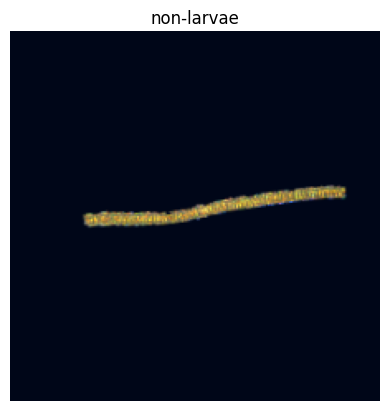

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                   [-1, 64]       6,422,592
             ReLU-14                   

In [11]:
optimizer_cnn_0 = optim.AdamW(cnn_0.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-6)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6892 | Val Loss: 0.6570 | Train cohen_kappa_fn: 0.1572 | Val cohen_kappa_fn: 0.1541 | Train accuracy_fn: 0.5150 | Val accuracy_fn: 0.4844 | Train f1_fn: 0.6079 | Val f1_fn: 0.5646
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6235 | Val Loss: 0.5510 | Train cohen_kappa_fn: 0.2393 | Val cohen_kappa_fn: 0.2234 | Train accuracy_fn: 0.5952 | Val accuracy_fn: 0.5750 | Train f1_fn: 0.6885 | Val f1_fn: 0.6667
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5605 | Val Loss: 0.6027 | Train cohen_kappa_fn: 0.1328 | Val cohen_kappa_fn: 0.0952 | Train accuracy_fn: 0.4348 | Val accuracy_fn: 0.3688 | Train f1_fn: 0.4983 | Val f1_fn: 0.4024
  ❄️ No improvement, model won't be saved!


📘 Epoch 4 | Train Loss: 0.5196 | Val Loss: 0.5400 | Train cohen_kappa_fn: 0.2219 | Val cohen_kappa_fn: 0.1410 | Train accuracy_fn: 0.5664 | Val accuracy_fn: 0.4469 | Train f1_fn: 0.6567 | Val f1_fn: 0.5124
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4184 | Val Loss: 0.5501 | Train cohen_kappa_fn: 0.3350 | Val cohen_kappa_fn: 0.1710 | Train accuracy_fn: 0.6917 | Val accuracy_fn: 0.5000 | Train f1_fn: 0.7796 | Val f1_fn: 0.5812
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.3627 | Val Loss: 1.0163 | Train cohen_kappa_fn: 0.2134 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8672 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.9272 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.3803 | Val Loss: 0.4041 | Train cohen_kappa_fn: 0.3326 | Val cohen_kappa_fn: 0.2354 | Train accuracy_fn: 0.6767 | Val accuracy_fn: 0.5750 | Train f1_fn: 0.7637 | Val f1_fn: 0.6634
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2537 | Val Loss: 0.6220 | Train cohen_kappa_fn: 0.4629 | Val cohen_kappa_fn: 0.3119 | Train accuracy_fn: 0.7920 | Val accuracy_fn: 0.6781 | Train f1_fn: 0.8621 | Val f1_fn: 0.7685
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3640 | Val Loss: 0.5808 | Train cohen_kappa_fn: 0.6542 | Val cohen_kappa_fn: 0.5594 | Train accuracy_fn: 0.9248 | Val accuracy_fn: 0.9094 | Train f1_fn: 0.9571 | Val f1_fn: 0.9489
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.3366 | Val Loss: 0.3265 | Train cohen_kappa_fn: 0.4547 | Val cohen_kappa_fn: 0.4217 | Train accuracy_fn: 0.7732 | Val accuracy_fn: 0.7469 | Train f1_fn: 0.8454 | Val f1_fn: 0.8235
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2818 | Val Loss: 0.3778 | Train cohen_kappa_fn: 0.4547 | Val cohen_kappa_fn: 0.3469 | Train accuracy_fn: 0.7732 | Val accuracy_fn: 0.6875 | Train f1_fn: 0.8454 | Val f1_fn: 0.7727
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2792 | Val Loss: 0.2761 | Train cohen_kappa_fn: 0.4699 | Val cohen_kappa_fn: 0.4961 | Train accuracy_fn: 0.7832 | Val accuracy_fn: 0.8000 | Train f1_fn: 0.8533 | Val f1_fn: 0.8661
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2646 | Val Loss: 0.2291 | Train cohen_kappa_fn: 0.7020 | Val cohen_kappa_fn: 0.6912 | Train accuracy_fn: 0.9060 | Val accuracy_fn: 0.9000 | Train f1_fn: 0.9417 | Val f1_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2075 | Val Loss: 0.4901 | Train cohen_kappa_fn: 0.4204 | Val cohen_kappa_fn: 0.3065 | Train accuracy_fn: 0.7494 | Val accuracy_fn: 0.6562 | Train f1_fn: 0.8264 | Val f1_fn: 0.7454
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2222 | Val Loss: 0.9318 | Train cohen_kappa_fn: 0.5690 | Val cohen_kappa_fn: 0.4870 | Train accuracy_fn: 0.9123 | Val accuracy_fn: 0.9000 | Train f1_fn: 0.9506 | Val f1_fn: 0.9441
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1880 | Val Loss: 0.1737 | Train cohen_kappa_fn: 0.7239 | Val cohen_kappa_fn: 0.6878 | Train accuracy_fn: 0.9110 | Val accuracy_fn: 0.8969 | Train f1_fn: 0.9445 | Val f1_fn: 0.9352
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2159 | Val Loss: 0.1627 | Train cohen_kappa_fn: 0.8336 | Val cohen_kappa_fn: 0.8393 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9563 | Train f1_fn: 0.9731 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2179 | Val Loss: 1.3303 | Train cohen_kappa_fn: 0.4632 | Val cohen_kappa_fn: 0.2967 | Train accuracy_fn: 0.8972 | Val accuracy_fn: 0.8750 | Train f1_fn: 0.9427 | Val f1_fn: 0.9310
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1199 | Val Loss: 0.2251 | Train cohen_kappa_fn: 0.9058 | Val cohen_kappa_fn: 0.7863 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9851 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1329 | Val Loss: 0.1849 | Train cohen_kappa_fn: 0.8097 | Val cohen_kappa_fn: 0.7224 | Train accuracy_fn: 0.9436 | Val accuracy_fn: 0.9125 | Train f1_fn: 0.9656 | Val f1_fn: 0.9457
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1355 | Val Loss: 0.4199 | Train cohen_kappa_fn: 0.8883 | Val cohen_kappa_fn: 0.7266 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9344 | Train f1_fn: 0.9839 | Val f1_fn: 0.9619
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2526 | Val Loss: 0.3143 | Train cohen_kappa_fn: 0.8744 | Val cohen_kappa_fn: 0.7898 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9500 | Train f1_fn: 0.9817 | Val f1_fn: 0.9710
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


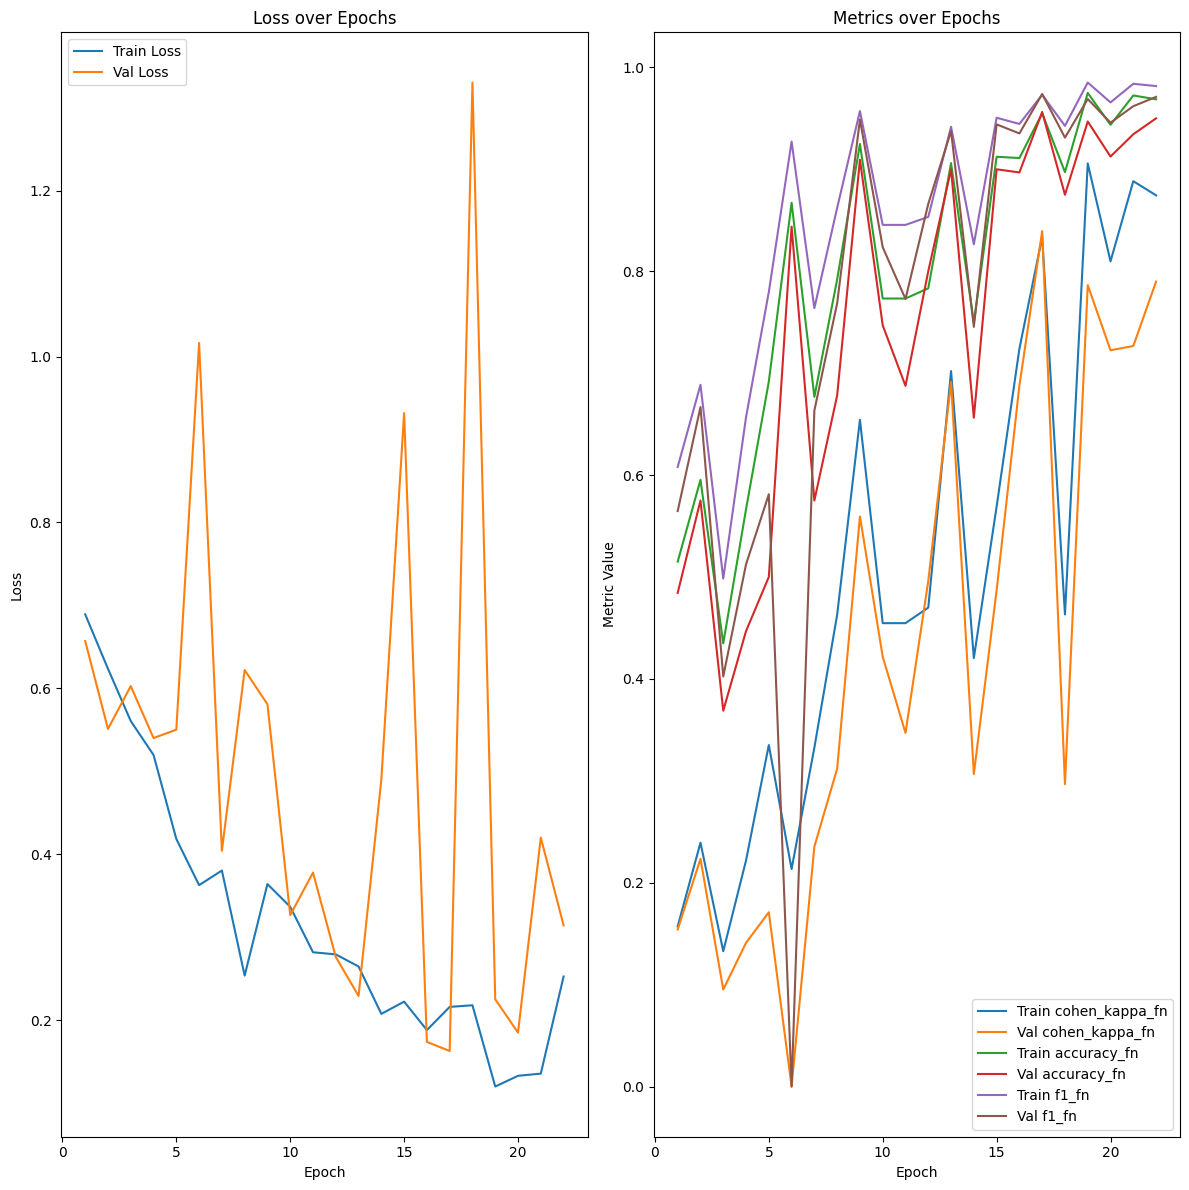

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2074 | Test cohen_kappa_fn: 0.9020 | Test accuracy_fn: 0.9750 | Test f1_fn: 0.9853


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

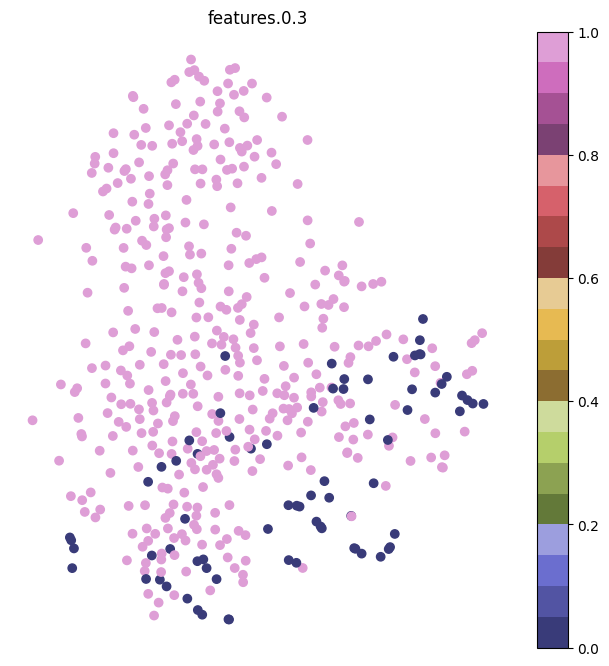

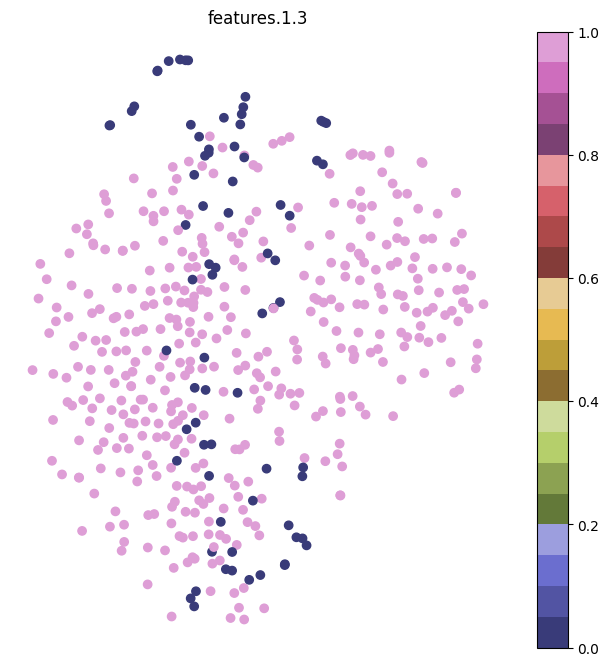

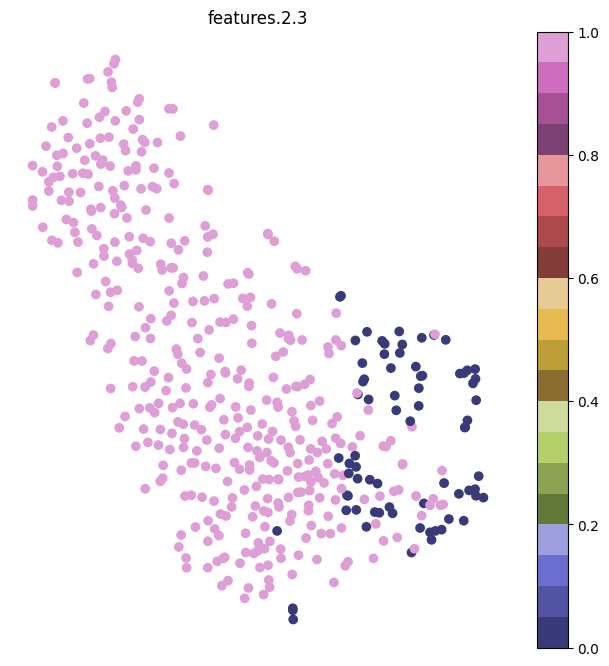

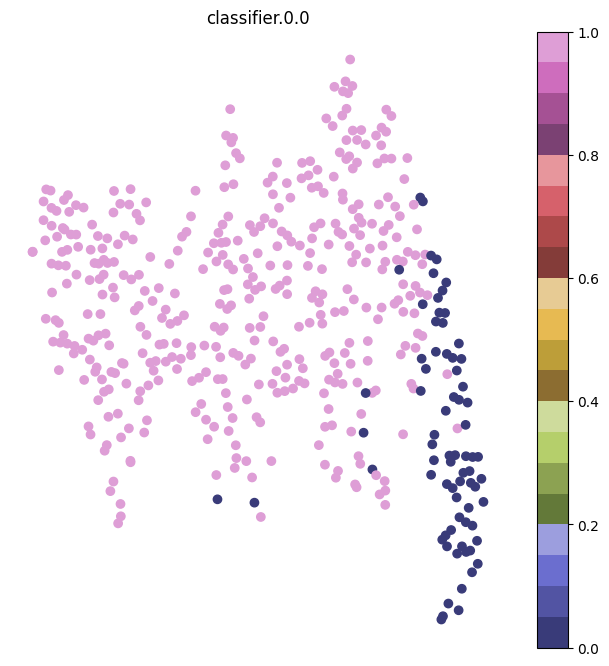

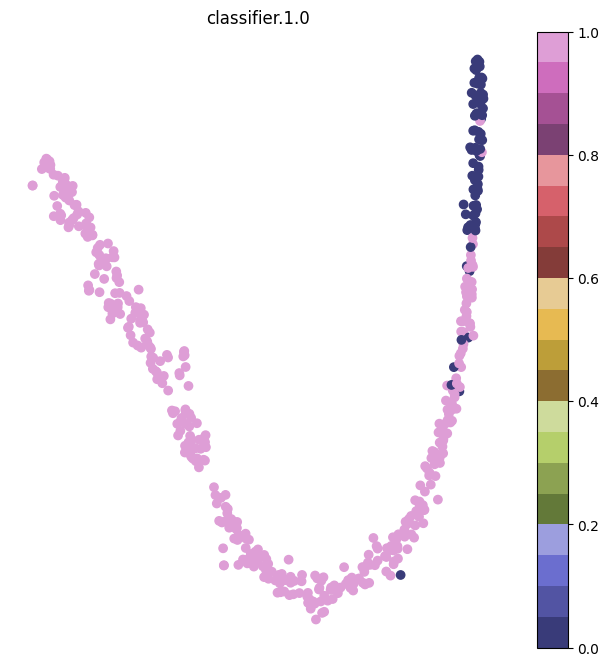

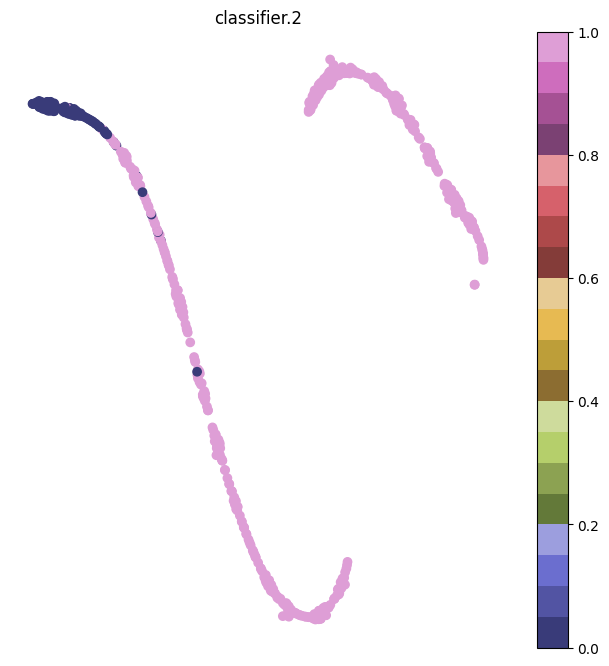

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


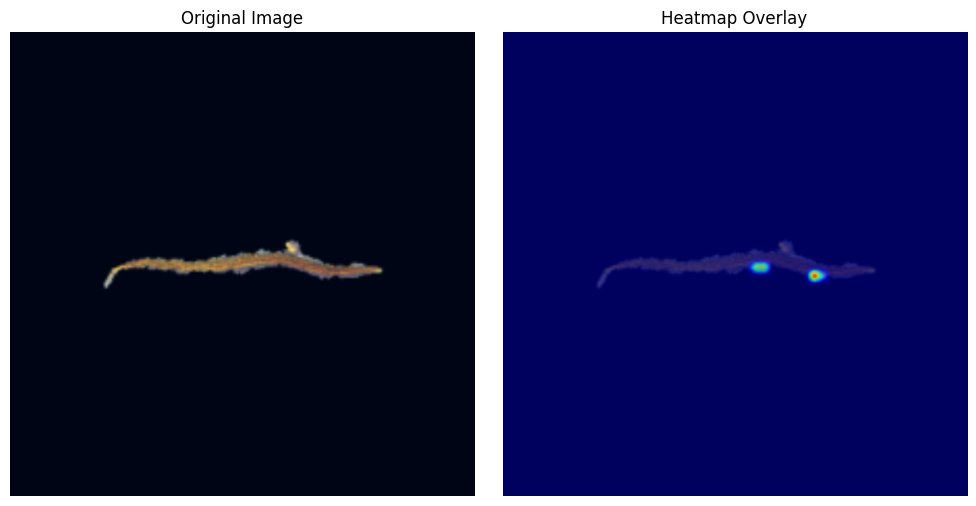

  Generating heatmap for Larvae...
  Predicted label is Larvae!


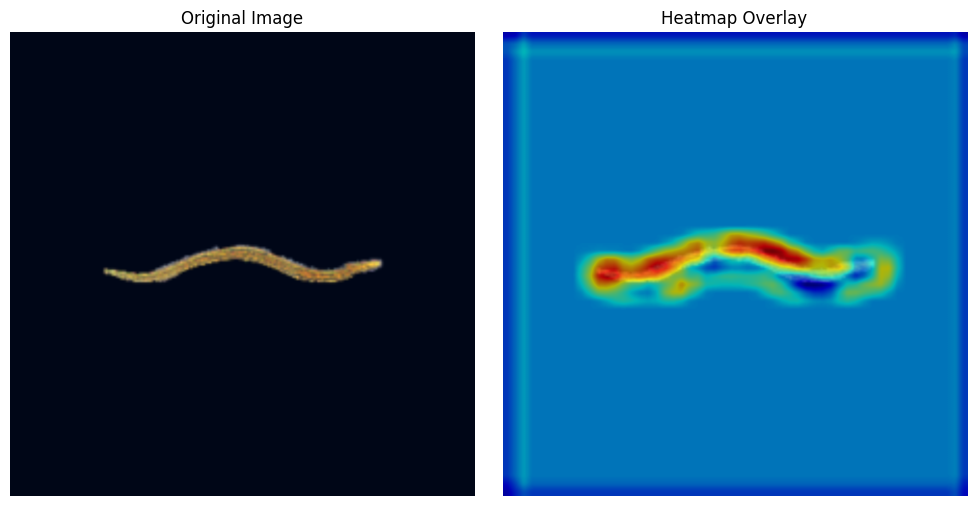

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [18]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                   [-1, 64]       6,422,592
             ReLU-14                   

In [19]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-6)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6907 | Val Loss: 0.6877 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6775 | Val Loss: 0.6772 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6567 | Val Loss: 0.6480 | Train cohen_kappa_fn: 0.0111 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.9164 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6353 | Val Loss: 0.6324 | Train cohen_kappa_fn: 0.2382 | Val cohen_kappa_fn: 0.0204 | Train accuracy_fn: 0.8509 | Val accuracy_fn: 0.8406 | Train f1_fn: 0.9165 | Val f1_fn: 0.9131
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6072 | Val Loss: 0.5902 | Train cohen_kappa_fn: 0.2755 | Val cohen_kappa_fn: 0.2829 | Train accuracy_fn: 0.6742 | Val accuracy_fn: 0.7000 | Train f1_fn: 0.7703 | Val f1_fn: 0.7949
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5789 | Val Loss: 0.5611 | Train cohen_kappa_fn: 0.1979 | Val cohen_kappa_fn: 0.2003 | Train accuracy_fn: 0.5426 | Val accuracy_fn: 0.5469 | Train f1_fn: 0.6324 | Val f1_fn: 0.6366
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5424 | Val Loss: 0.4857 | Train cohen_kappa_fn: 0.3740 | Val cohen_kappa_fn: 0.4173 | Train accuracy_fn: 0.7293 | Val accuracy_fn: 0.7688 | Train f1_fn: 0.8125 | Val f1_fn: 0.8452
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5177 | Val Loss: 0.4510 | Train cohen_kappa_fn: 0.3060 | Val cohen_kappa_fn: 0.3691 | Train accuracy_fn: 0.6704 | Val accuracy_fn: 0.7063 | Train f1_fn: 0.7616 | Val f1_fn: 0.7892
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4602 | Val Loss: 0.4843 | Train cohen_kappa_fn: 0.2491 | Val cohen_kappa_fn: 0.2000 | Train accuracy_fn: 0.5952 | Val accuracy_fn: 0.5312 | Train f1_fn: 0.6861 | Val f1_fn: 0.6154
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4697 | Val Loss: 0.5144 | Train cohen_kappa_fn: 0.2468 | Val cohen_kappa_fn: 0.1882 | Train accuracy_fn: 0.5927 | Val accuracy_fn: 0.5156 | Train f1_fn: 0.6835 | Val f1_fn: 0.5974
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.4024 | Val Loss: 0.4081 | Train cohen_kappa_fn: 0.3847 | Val cohen_kappa_fn: 0.3293 | Train accuracy_fn: 0.7318 | Val accuracy_fn: 0.6719 | Train f1_fn: 0.8136 | Val f1_fn: 0.7586
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3905 | Val Loss: 0.3726 | Train cohen_kappa_fn: 0.5420 | Val cohen_kappa_fn: 0.4260 | Train accuracy_fn: 0.8333 | Val accuracy_fn: 0.7500 | Train f1_fn: 0.8920 | Val f1_fn: 0.8261
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3743 | Val Loss: 0.3779 | Train cohen_kappa_fn: 0.6065 | Val cohen_kappa_fn: 0.3966 | Train accuracy_fn: 0.8609 | Val accuracy_fn: 0.7281 | Train f1_fn: 0.9107 | Val f1_fn: 0.8079
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.3377 | Val Loss: 0.3953 | Train cohen_kappa_fn: 0.4755 | Val cohen_kappa_fn: 0.3158 | Train accuracy_fn: 0.7882 | Val accuracy_fn: 0.6594 | Train f1_fn: 0.8574 | Val f1_fn: 0.7471
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2984 | Val Loss: 0.3012 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.6002 | Train accuracy_fn: 0.9098 | Val accuracy_fn: 0.8594 | Train f1_fn: 0.9442 | Val f1_fn: 0.9098
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3156 | Val Loss: 0.3184 | Train cohen_kappa_fn: 0.5764 | Val cohen_kappa_fn: 0.4753 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.7906 | Train f1_fn: 0.9001 | Val f1_fn: 0.8595
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3122 | Val Loss: 0.2846 | Train cohen_kappa_fn: 0.5833 | Val cohen_kappa_fn: 0.6002 | Train accuracy_fn: 0.8484 | Val accuracy_fn: 0.8594 | Train f1_fn: 0.9017 | Val f1_fn: 0.9098
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2851 | Val Loss: 0.3297 | Train cohen_kappa_fn: 0.4758 | Val cohen_kappa_fn: 0.4381 | Train accuracy_fn: 0.7870 | Val accuracy_fn: 0.7625 | Train f1_fn: 0.8562 | Val f1_fn: 0.8369
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2672 | Val Loss: 0.2696 | Train cohen_kappa_fn: 0.6901 | Val cohen_kappa_fn: 0.6693 | Train accuracy_fn: 0.8985 | Val accuracy_fn: 0.9000 | Train f1_fn: 0.9364 | Val f1_fn: 0.9387
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2324 | Val Loss: 0.2375 | Train cohen_kappa_fn: 0.7178 | Val cohen_kappa_fn: 0.7106 | Train accuracy_fn: 0.9098 | Val accuracy_fn: 0.9156 | Train f1_fn: 0.9438 | Val f1_fn: 0.9488
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2284 | Val Loss: 0.2438 | Train cohen_kappa_fn: 0.7194 | Val cohen_kappa_fn: 0.7106 | Train accuracy_fn: 0.9110 | Val accuracy_fn: 0.9156 | Train f1_fn: 0.9447 | Val f1_fn: 0.9488
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2239 | Val Loss: 0.2606 | Train cohen_kappa_fn: 0.8089 | Val cohen_kappa_fn: 0.7668 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9375 | Train f1_fn: 0.9666 | Val f1_fn: 0.9628
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2026 | Val Loss: 0.3035 | Train cohen_kappa_fn: 0.8599 | Val cohen_kappa_fn: 0.7692 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9406 | Train f1_fn: 0.9767 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2022 | Val Loss: 0.2268 | Train cohen_kappa_fn: 0.6625 | Val cohen_kappa_fn: 0.6828 | Train accuracy_fn: 0.8860 | Val accuracy_fn: 0.9000 | Train f1_fn: 0.9278 | Val f1_fn: 0.9380
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2019 | Val Loss: 0.2821 | Train cohen_kappa_fn: 0.5147 | Val cohen_kappa_fn: 0.4803 | Train accuracy_fn: 0.8108 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8743 | Val f1_fn: 0.8619
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2000 | Val Loss: 0.2511 | Train cohen_kappa_fn: 0.8311 | Val cohen_kappa_fn: 0.7609 | Train accuracy_fn: 0.9511 | Val accuracy_fn: 0.9344 | Train f1_fn: 0.9704 | Val f1_fn: 0.9607
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2151 | Val Loss: 0.2177 | Train cohen_kappa_fn: 0.6654 | Val cohen_kappa_fn: 0.7484 | Train accuracy_fn: 0.8872 | Val accuracy_fn: 0.9250 | Train f1_fn: 0.9287 | Val f1_fn: 0.9542
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.1888 | Val Loss: 0.2656 | Train cohen_kappa_fn: 0.8378 | Val cohen_kappa_fn: 0.8006 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9500 | Train f1_fn: 0.9720 | Val f1_fn: 0.9707
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1948 | Val Loss: 0.2593 | Train cohen_kappa_fn: 0.8123 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9665 | Val f1_fn: 0.9687
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1794 | Val Loss: 0.3563 | Train cohen_kappa_fn: 0.8549 | Val cohen_kappa_fn: 0.7863 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9469 | Train f1_fn: 0.9760 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1645 | Val Loss: 0.2207 | Train cohen_kappa_fn: 0.7822 | Val cohen_kappa_fn: 0.7870 | Train accuracy_fn: 0.9336 | Val accuracy_fn: 0.9406 | Train f1_fn: 0.9592 | Val f1_fn: 0.9644
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1647 | Val Loss: 0.2657 | Train cohen_kappa_fn: 0.8123 | Val cohen_kappa_fn: 0.7831 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9438 | Train f1_fn: 0.9665 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


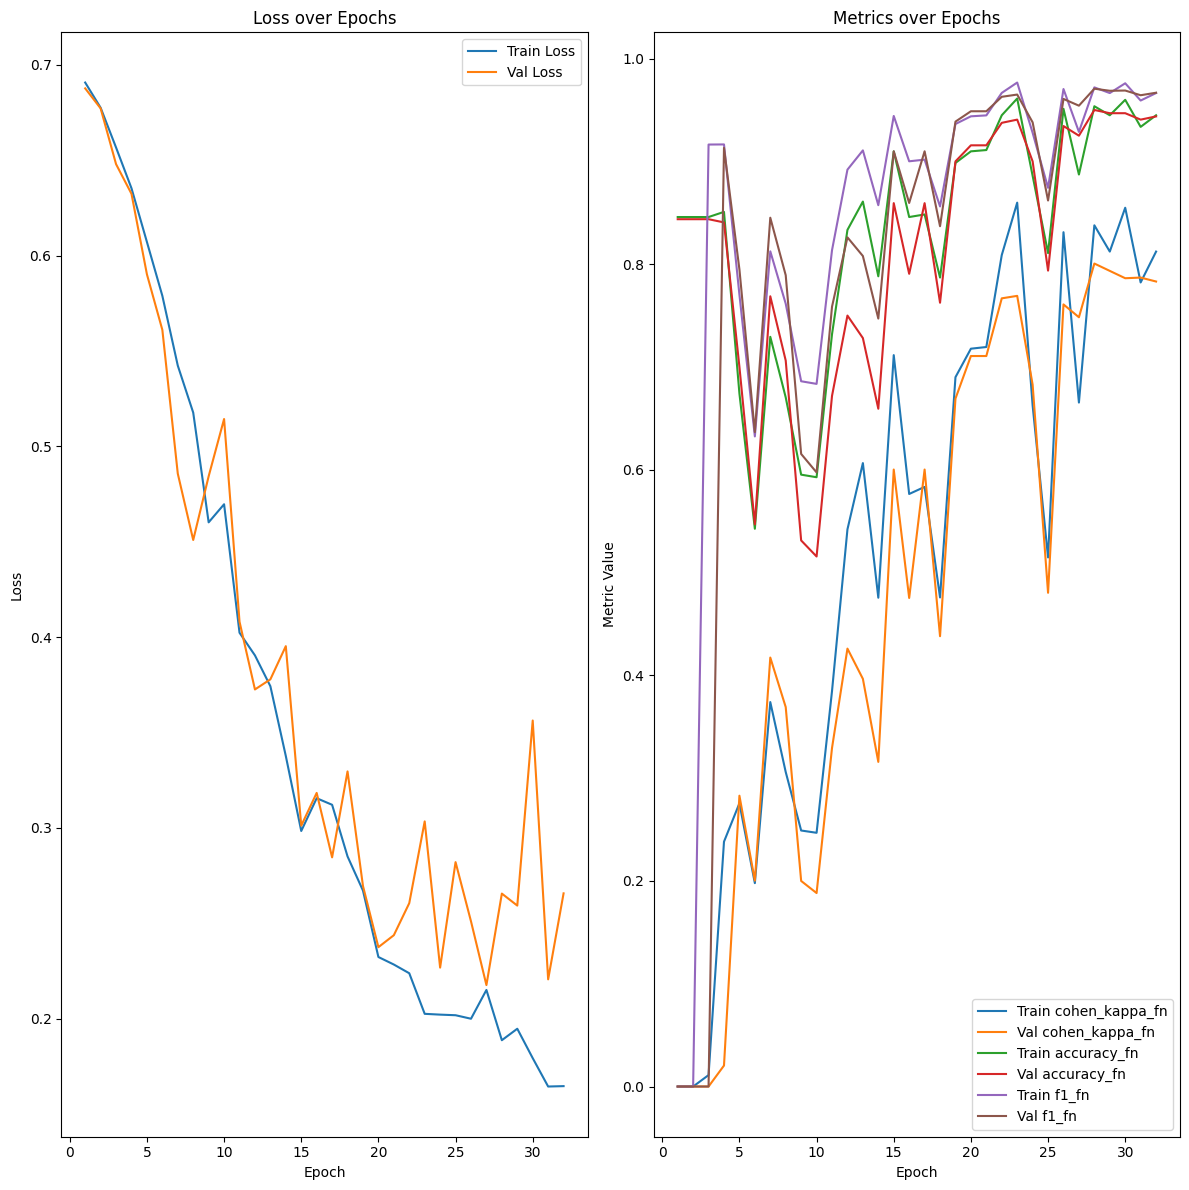

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2051 | Test cohen_kappa_fn: 0.7530 | Test accuracy_fn: 0.9292 | Test f1_fn: 0.9572


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

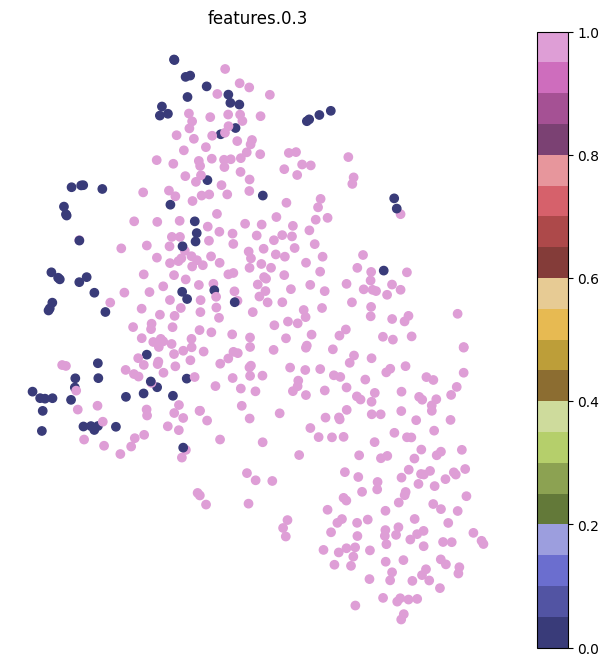

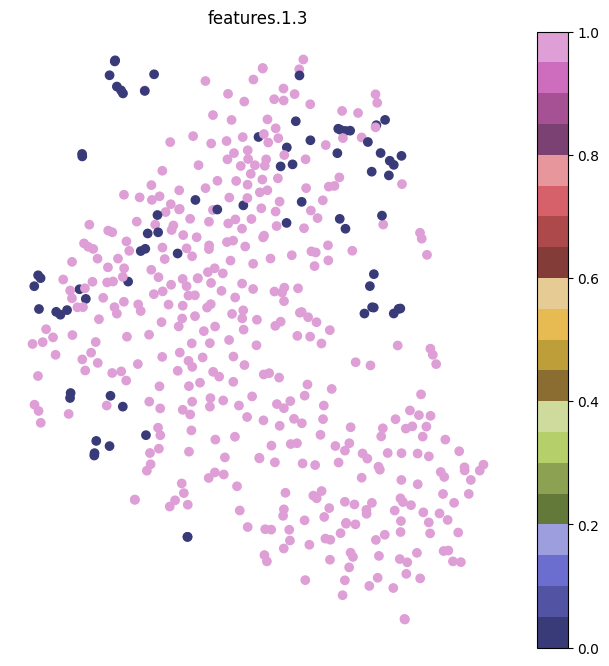

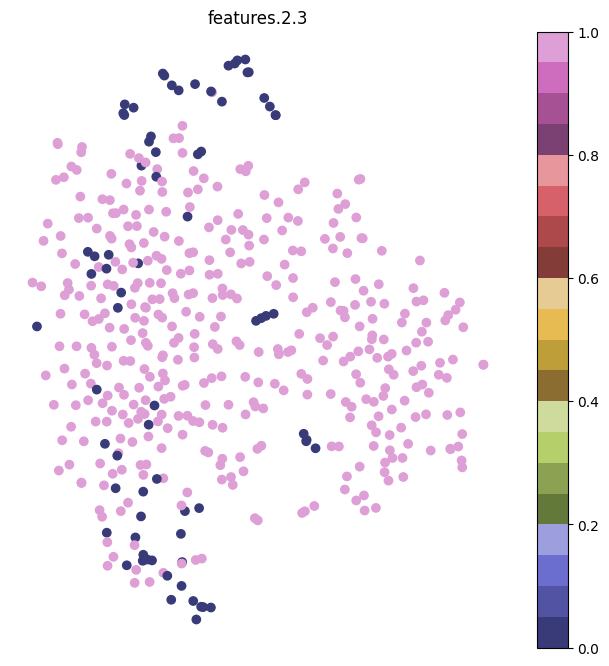

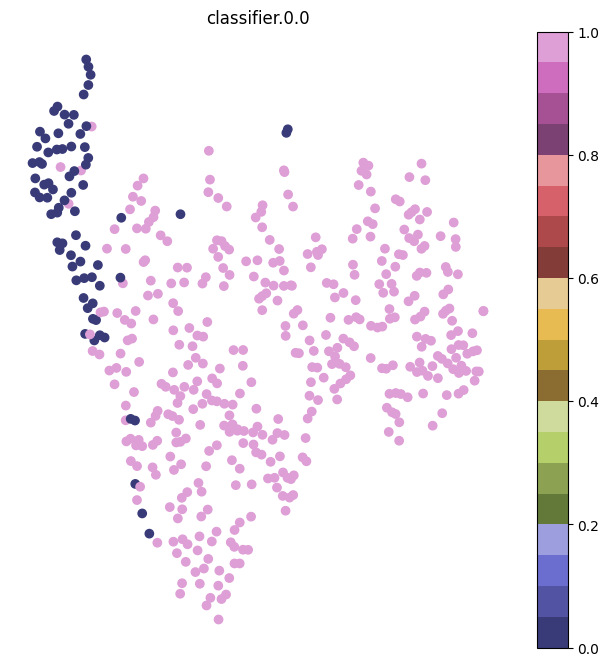

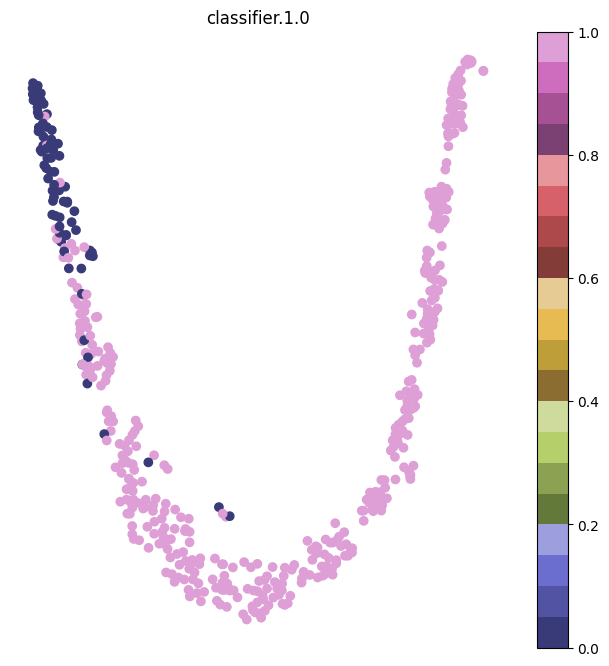

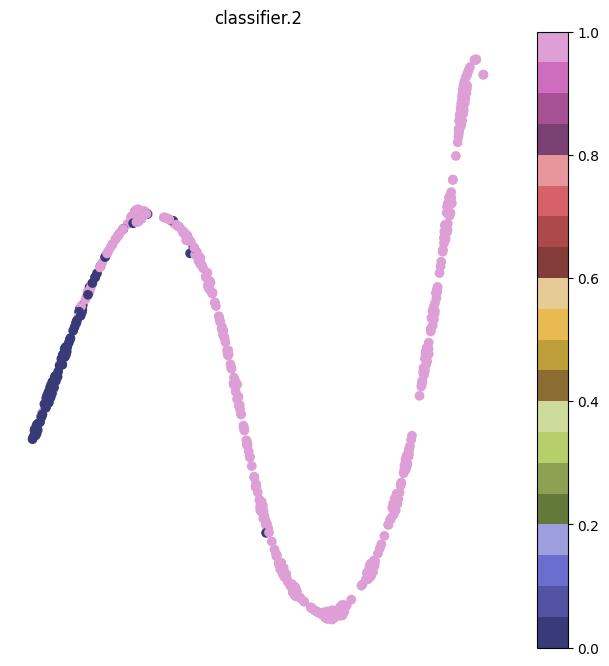

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


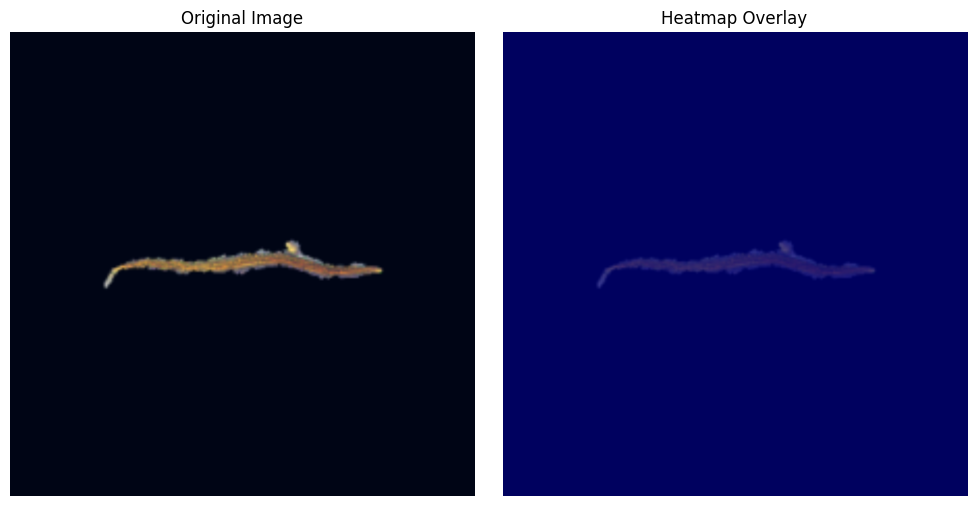

  Generating heatmap for Larvae...
  Predicted label is Larvae!


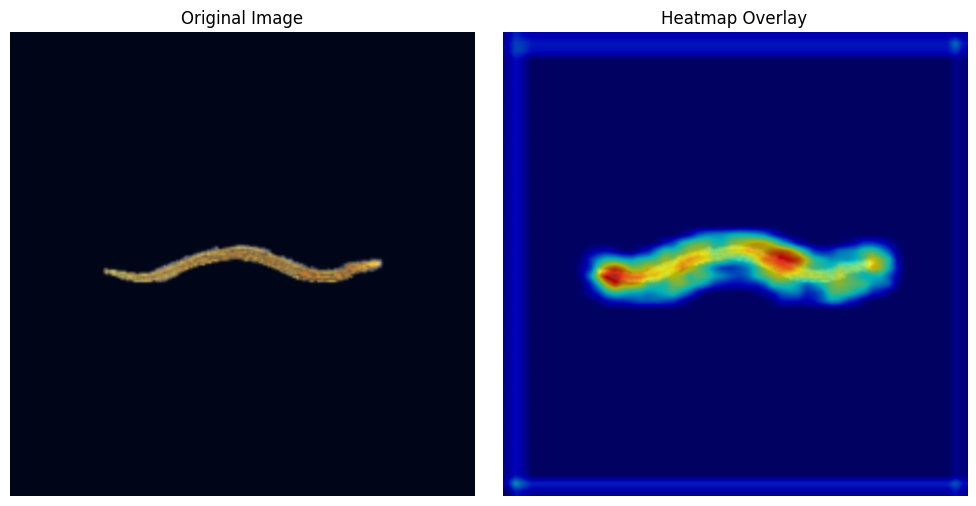

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                   [-1, 64]       6,422,592
             ReLU-14                   

In [27]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-6)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6922 | Train cohen_kappa_fn: 0.0714 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8496 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.9180 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6919 | Val Loss: 0.6915 | Train cohen_kappa_fn: 0.0137 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8471 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.9171 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6898 | Val Loss: 0.6904 | Train cohen_kappa_fn: 0.1178 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8571 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.9221 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6891 | Val Loss: 0.6891 | Train cohen_kappa_fn: 0.0538 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8509 | Val accuracy_fn: 0.8438 | Train f1_fn: 0.9190 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6873 | Val Loss: 0.6876 | Train cohen_kappa_fn: 0.1689 | Val cohen_kappa_fn: 0.0333 | Train accuracy_fn: 0.8596 | Val accuracy_fn: 0.8469 | Train f1_fn: 0.9231 | Val f1_fn: 0.9168
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6855 | Val Loss: 0.6861 | Train cohen_kappa_fn: 0.2424 | Val cohen_kappa_fn: 0.0333 | Train accuracy_fn: 0.8609 | Val accuracy_fn: 0.8469 | Train f1_fn: 0.9229 | Val f1_fn: 0.9168
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6855 | Val Loss: 0.6835 | Train cohen_kappa_fn: 0.3322 | Val cohen_kappa_fn: 0.0333 | Train accuracy_fn: 0.8722 | Val accuracy_fn: 0.8469 | Train f1_fn: 0.9287 | Val f1_fn: 0.9168
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6806 | Val Loss: 0.6822 | Train cohen_kappa_fn: 0.2985 | Val cohen_kappa_fn: 0.0333 | Train accuracy_fn: 0.8596 | Val accuracy_fn: 0.8469 | Train f1_fn: 0.9211 | Val f1_fn: 0.9168
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6797 | Val Loss: 0.6794 | Train cohen_kappa_fn: 0.2861 | Val cohen_kappa_fn: 0.0657 | Train accuracy_fn: 0.8596 | Val accuracy_fn: 0.8500 | Train f1_fn: 0.9213 | Val f1_fn: 0.9184
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6775 | Val Loss: 0.6767 | Train cohen_kappa_fn: 0.2901 | Val cohen_kappa_fn: 0.1205 | Train accuracy_fn: 0.8346 | Val accuracy_fn: 0.8531 | Train f1_fn: 0.9045 | Val f1_fn: 0.9197
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.6743 | Val Loss: 0.6728 | Train cohen_kappa_fn: 0.3027 | Val cohen_kappa_fn: 0.1712 | Train accuracy_fn: 0.8145 | Val accuracy_fn: 0.8562 | Train f1_fn: 0.8899 | Val f1_fn: 0.9210
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.6710 | Val Loss: 0.6712 | Train cohen_kappa_fn: 0.2539 | Val cohen_kappa_fn: 0.1205 | Train accuracy_fn: 0.7957 | Val accuracy_fn: 0.8531 | Train f1_fn: 0.8779 | Val f1_fn: 0.9197
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.6641 | Val Loss: 0.6681 | Train cohen_kappa_fn: 0.2309 | Val cohen_kappa_fn: 0.2103 | Train accuracy_fn: 0.7794 | Val accuracy_fn: 0.8562 | Train f1_fn: 0.8667 | Val f1_fn: 0.9204
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.6638 | Val Loss: 0.6601 | Train cohen_kappa_fn: 0.2833 | Val cohen_kappa_fn: 0.1950 | Train accuracy_fn: 0.7945 | Val accuracy_fn: 0.8500 | Train f1_fn: 0.8758 | Val f1_fn: 0.9167
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.6549 | Val Loss: 0.6611 | Train cohen_kappa_fn: 0.3412 | Val cohen_kappa_fn: 0.1560 | Train accuracy_fn: 0.8208 | Val accuracy_fn: 0.8500 | Train f1_fn: 0.8930 | Val f1_fn: 0.9172
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.6560 | Val Loss: 0.6583 | Train cohen_kappa_fn: 0.2110 | Val cohen_kappa_fn: 0.1686 | Train accuracy_fn: 0.7669 | Val accuracy_fn: 0.8469 | Train f1_fn: 0.8580 | Val f1_fn: 0.9151
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.6529 | Val Loss: 0.6478 | Train cohen_kappa_fn: 0.2387 | Val cohen_kappa_fn: 0.2207 | Train accuracy_fn: 0.7870 | Val accuracy_fn: 0.8531 | Train f1_fn: 0.8720 | Val f1_fn: 0.9183
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.6481 | Val Loss: 0.6495 | Train cohen_kappa_fn: 0.2730 | Val cohen_kappa_fn: 0.2422 | Train accuracy_fn: 0.7632 | Val accuracy_fn: 0.8344 | Train f1_fn: 0.8518 | Val f1_fn: 0.9055
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.6424 | Val Loss: 0.6440 | Train cohen_kappa_fn: 0.2609 | Val cohen_kappa_fn: 0.2393 | Train accuracy_fn: 0.7393 | Val accuracy_fn: 0.8125 | Train f1_fn: 0.8328 | Val f1_fn: 0.8905
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.6414 | Val Loss: 0.6457 | Train cohen_kappa_fn: 0.2681 | Val cohen_kappa_fn: 0.2085 | Train accuracy_fn: 0.7882 | Val accuracy_fn: 0.8406 | Train f1_fn: 0.8717 | Val f1_fn: 0.9104
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.6326 | Val Loss: 0.6396 | Train cohen_kappa_fn: 0.2602 | Val cohen_kappa_fn: 0.2589 | Train accuracy_fn: 0.7494 | Val accuracy_fn: 0.8094 | Train f1_fn: 0.8413 | Val f1_fn: 0.8877
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.6307 | Val Loss: 0.6325 | Train cohen_kappa_fn: 0.2972 | Val cohen_kappa_fn: 0.3174 | Train accuracy_fn: 0.7406 | Val accuracy_fn: 0.8156 | Train f1_fn: 0.8310 | Val f1_fn: 0.8901
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.6188 | Val Loss: 0.6257 | Train cohen_kappa_fn: 0.3253 | Val cohen_kappa_fn: 0.2500 | Train accuracy_fn: 0.7907 | Val accuracy_fn: 0.8313 | Train f1_fn: 0.8708 | Val f1_fn: 0.9032
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.6172 | Val Loss: 0.6202 | Train cohen_kappa_fn: 0.2686 | Val cohen_kappa_fn: 0.2950 | Train accuracy_fn: 0.7243 | Val accuracy_fn: 0.8156 | Train f1_fn: 0.8191 | Val f1_fn: 0.8909
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.6198 | Val Loss: 0.6214 | Train cohen_kappa_fn: 0.3362 | Val cohen_kappa_fn: 0.3271 | Train accuracy_fn: 0.7757 | Val accuracy_fn: 0.8313 | Train f1_fn: 0.8580 | Val f1_fn: 0.9011
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.6115 | Val Loss: 0.6224 | Train cohen_kappa_fn: 0.2952 | Val cohen_kappa_fn: 0.3064 | Train accuracy_fn: 0.7343 | Val accuracy_fn: 0.8156 | Train f1_fn: 0.8257 | Val f1_fn: 0.8905
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.6138 | Val Loss: 0.6144 | Train cohen_kappa_fn: 0.2967 | Val cohen_kappa_fn: 0.3385 | Train accuracy_fn: 0.7331 | Val accuracy_fn: 0.8156 | Train f1_fn: 0.8244 | Val f1_fn: 0.8893
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.6039 | Val Loss: 0.6134 | Train cohen_kappa_fn: 0.3239 | Val cohen_kappa_fn: 0.3174 | Train accuracy_fn: 0.7569 | Val accuracy_fn: 0.8156 | Train f1_fn: 0.8430 | Val f1_fn: 0.8901
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.6039 | Val Loss: 0.6083 | Train cohen_kappa_fn: 0.2995 | Val cohen_kappa_fn: 0.3234 | Train accuracy_fn: 0.7281 | Val accuracy_fn: 0.7969 | Train f1_fn: 0.8196 | Val f1_fn: 0.8757
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.6011 | Val Loss: 0.6064 | Train cohen_kappa_fn: 0.3016 | Val cohen_kappa_fn: 0.3290 | Train accuracy_fn: 0.7343 | Val accuracy_fn: 0.8000 | Train f1_fn: 0.8251 | Val f1_fn: 0.8779
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.6015 | Val Loss: 0.6027 | Train cohen_kappa_fn: 0.2878 | Val cohen_kappa_fn: 0.3274 | Train accuracy_fn: 0.7143 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8081 | Val f1_fn: 0.8731
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.5997 | Val Loss: 0.6047 | Train cohen_kappa_fn: 0.2945 | Val cohen_kappa_fn: 0.3274 | Train accuracy_fn: 0.7243 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8167 | Val f1_fn: 0.8731
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.5900 | Val Loss: 0.6006 | Train cohen_kappa_fn: 0.3262 | Val cohen_kappa_fn: 0.3220 | Train accuracy_fn: 0.7431 | Val accuracy_fn: 0.8125 | Train f1_fn: 0.8307 | Val f1_fn: 0.8876
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.5890 | Val Loss: 0.6005 | Train cohen_kappa_fn: 0.2889 | Val cohen_kappa_fn: 0.3547 | Train accuracy_fn: 0.7419 | Val accuracy_fn: 0.8188 | Train f1_fn: 0.8328 | Val f1_fn: 0.8910
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.5824 | Val Loss: 0.6000 | Train cohen_kappa_fn: 0.3028 | Val cohen_kappa_fn: 0.3274 | Train accuracy_fn: 0.7306 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8216 | Val f1_fn: 0.8731
  🔥 New best model saved!


📘 Epoch 36 | Train Loss: 0.5907 | Val Loss: 0.5928 | Train cohen_kappa_fn: 0.2847 | Val cohen_kappa_fn: 0.3274 | Train accuracy_fn: 0.7143 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8084 | Val f1_fn: 0.8731
  🔥 New best model saved!


📘 Epoch 37 | Train Loss: 0.5806 | Val Loss: 0.5975 | Train cohen_kappa_fn: 0.3333 | Val cohen_kappa_fn: 0.3178 | Train accuracy_fn: 0.7481 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8346 | Val f1_fn: 0.8736
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.5876 | Val Loss: 0.5923 | Train cohen_kappa_fn: 0.3576 | Val cohen_kappa_fn: 0.3425 | Train accuracy_fn: 0.7707 | Val accuracy_fn: 0.8125 | Train f1_fn: 0.8523 | Val f1_fn: 0.8868
  🔥 New best model saved!


📘 Epoch 39 | Train Loss: 0.5795 | Val Loss: 0.5908 | Train cohen_kappa_fn: 0.3643 | Val cohen_kappa_fn: 0.3178 | Train accuracy_fn: 0.7632 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8452 | Val f1_fn: 0.8736
  🔥 New best model saved!


📘 Epoch 40 | Train Loss: 0.5729 | Val Loss: 0.5885 | Train cohen_kappa_fn: 0.3347 | Val cohen_kappa_fn: 0.3219 | Train accuracy_fn: 0.7406 | Val accuracy_fn: 0.7906 | Train f1_fn: 0.8276 | Val f1_fn: 0.8709
  🔥 New best model saved!


📘 Epoch 41 | Train Loss: 0.5833 | Val Loss: 0.5922 | Train cohen_kappa_fn: 0.3675 | Val cohen_kappa_fn: 0.3274 | Train accuracy_fn: 0.7594 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8416 | Val f1_fn: 0.8731
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.5682 | Val Loss: 0.5867 | Train cohen_kappa_fn: 0.3591 | Val cohen_kappa_fn: 0.3234 | Train accuracy_fn: 0.7657 | Val accuracy_fn: 0.7969 | Train f1_fn: 0.8478 | Val f1_fn: 0.8757
  🔥 New best model saved!


📘 Epoch 43 | Train Loss: 0.5654 | Val Loss: 0.5832 | Train cohen_kappa_fn: 0.3249 | Val cohen_kappa_fn: 0.3274 | Train accuracy_fn: 0.7444 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8320 | Val f1_fn: 0.8731
  🔥 New best model saved!


📘 Epoch 44 | Train Loss: 0.5627 | Val Loss: 0.5830 | Train cohen_kappa_fn: 0.3181 | Val cohen_kappa_fn: 0.3422 | Train accuracy_fn: 0.7306 | Val accuracy_fn: 0.7969 | Train f1_fn: 0.8201 | Val f1_fn: 0.8748
  🔥 New best model saved!


📘 Epoch 45 | Train Loss: 0.5758 | Val Loss: 0.5842 | Train cohen_kappa_fn: 0.3240 | Val cohen_kappa_fn: 0.3350 | Train accuracy_fn: 0.7393 | Val accuracy_fn: 0.7875 | Train f1_fn: 0.8275 | Val f1_fn: 0.8677
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.5743 | Val Loss: 0.5847 | Train cohen_kappa_fn: 0.2915 | Val cohen_kappa_fn: 0.3367 | Train accuracy_fn: 0.7268 | Val accuracy_fn: 0.7937 | Train f1_fn: 0.8192 | Val f1_fn: 0.8726
  ❄️ No improvement, model won't be saved!


📘 Epoch 47 | Train Loss: 0.5687 | Val Loss: 0.5816 | Train cohen_kappa_fn: 0.3374 | Val cohen_kappa_fn: 0.3313 | Train accuracy_fn: 0.7531 | Val accuracy_fn: 0.7906 | Train f1_fn: 0.8387 | Val f1_fn: 0.8704
  🔥 New best model saved!


📘 Epoch 48 | Train Loss: 0.5801 | Val Loss: 0.5846 | Train cohen_kappa_fn: 0.3681 | Val cohen_kappa_fn: 0.3313 | Train accuracy_fn: 0.7657 | Val accuracy_fn: 0.7906 | Train f1_fn: 0.8471 | Val f1_fn: 0.8704
  ❄️ No improvement, model won't be saved!


📘 Epoch 49 | Train Loss: 0.5825 | Val Loss: 0.5842 | Train cohen_kappa_fn: 0.3245 | Val cohen_kappa_fn: 0.3206 | Train accuracy_fn: 0.7331 | Val accuracy_fn: 0.7844 | Train f1_fn: 0.8218 | Val f1_fn: 0.8660
  ❄️ No improvement, model won't be saved!


📘 Epoch 50 | Train Loss: 0.5764 | Val Loss: 0.5878 | Train cohen_kappa_fn: 0.3341 | Val cohen_kappa_fn: 0.3347 | Train accuracy_fn: 0.7594 | Val accuracy_fn: 0.8031 | Train f1_fn: 0.8444 | Val f1_fn: 0.8800
  ❄️ No improvement, model won't be saved!


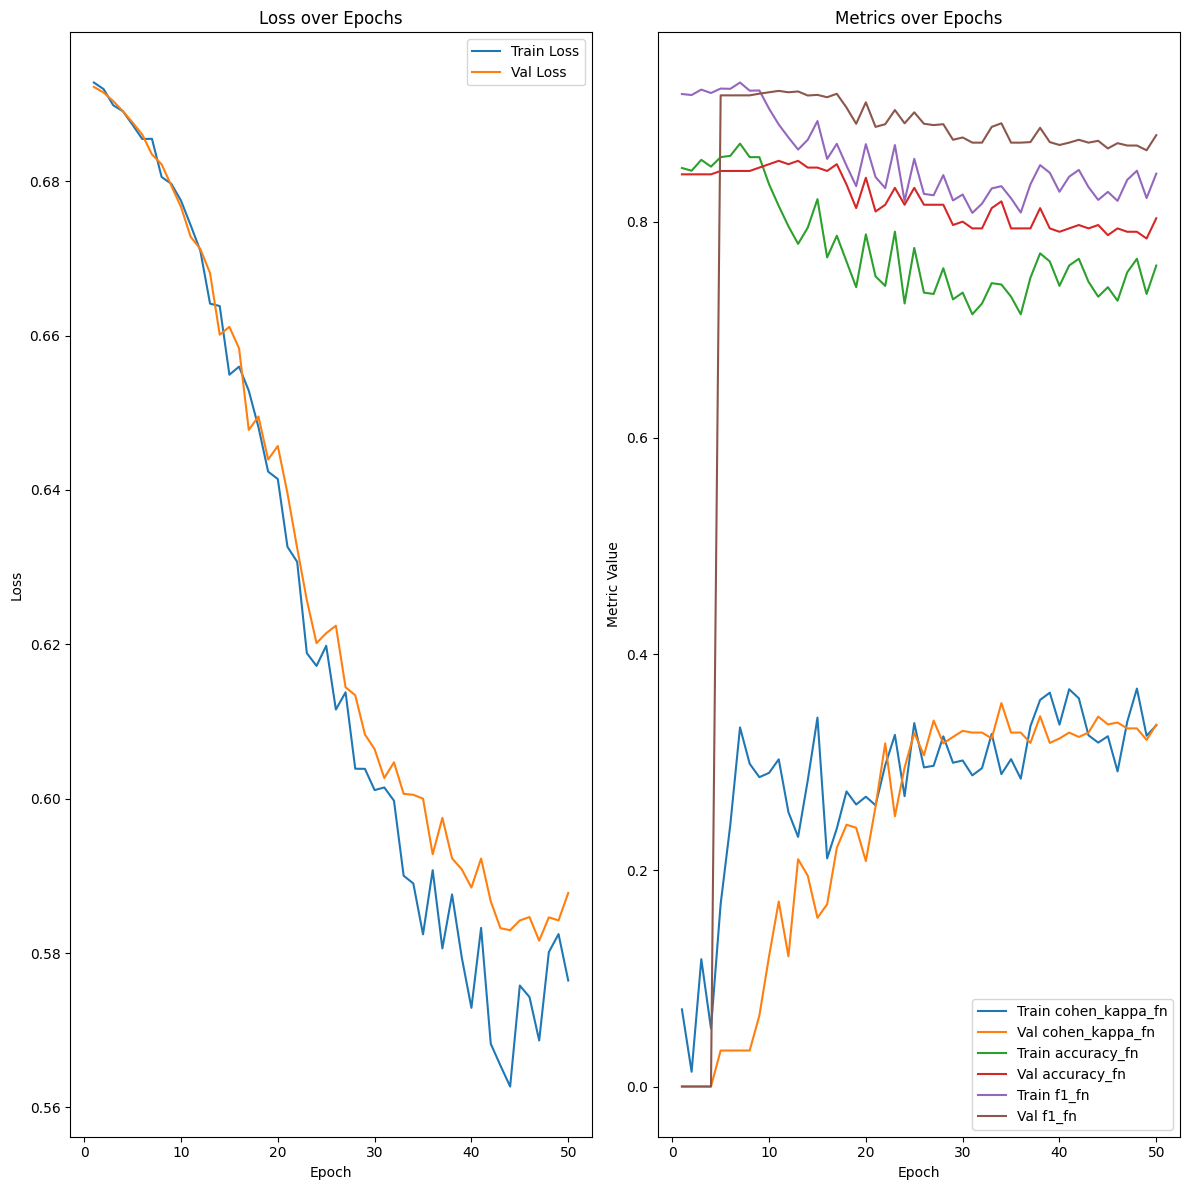

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.5847 | Test cohen_kappa_fn: 0.3501 | Test accuracy_fn: 0.8146 | Test f1_fn: 0.8881


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

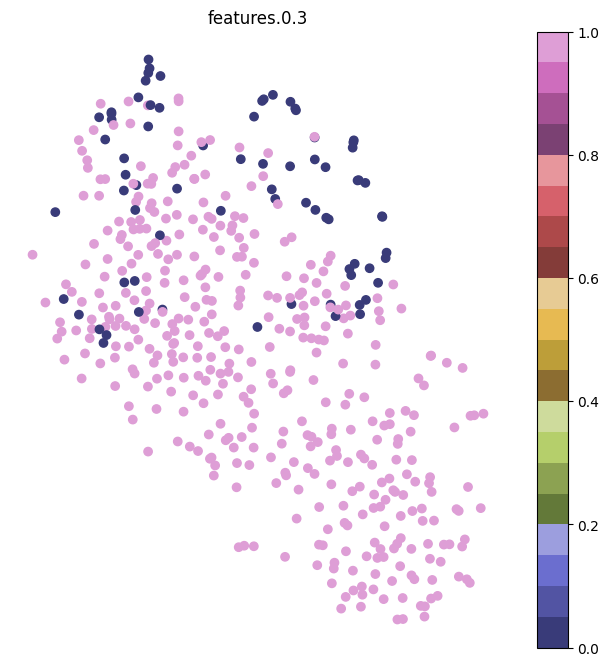

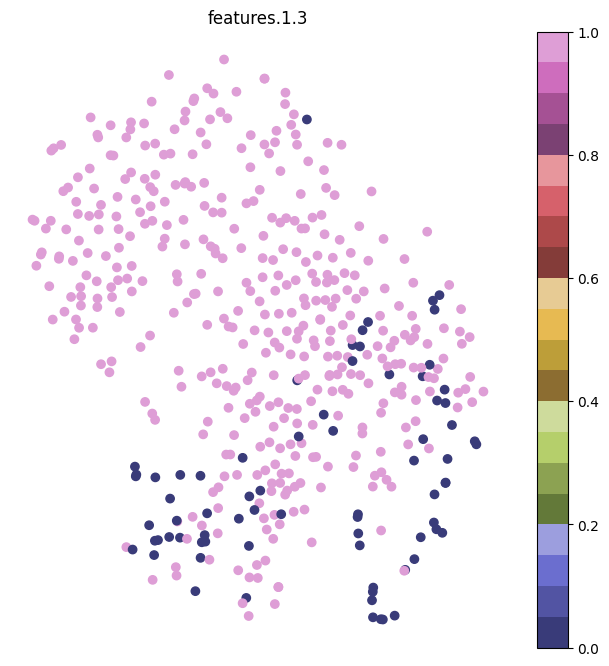

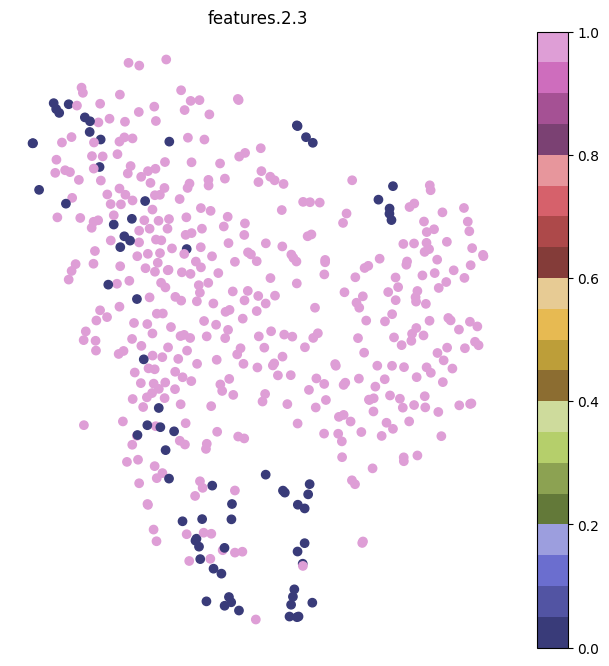

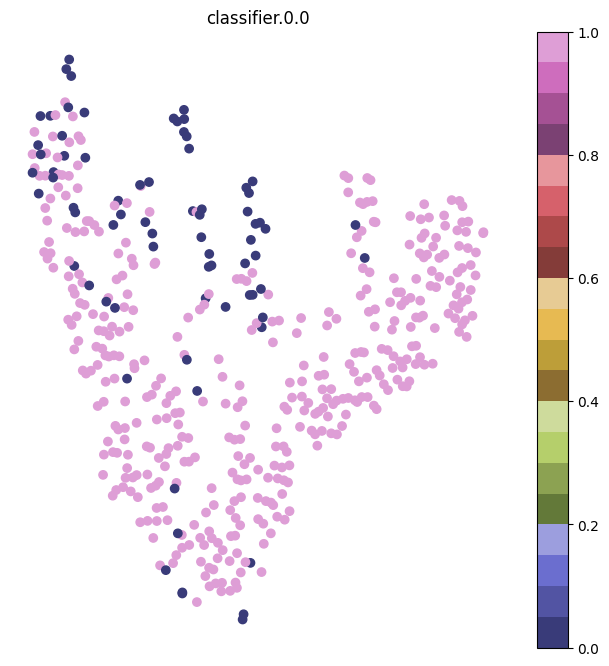

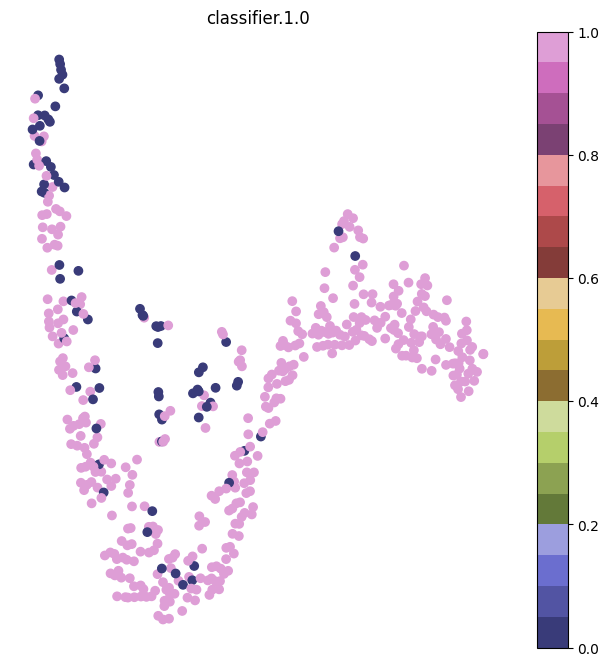

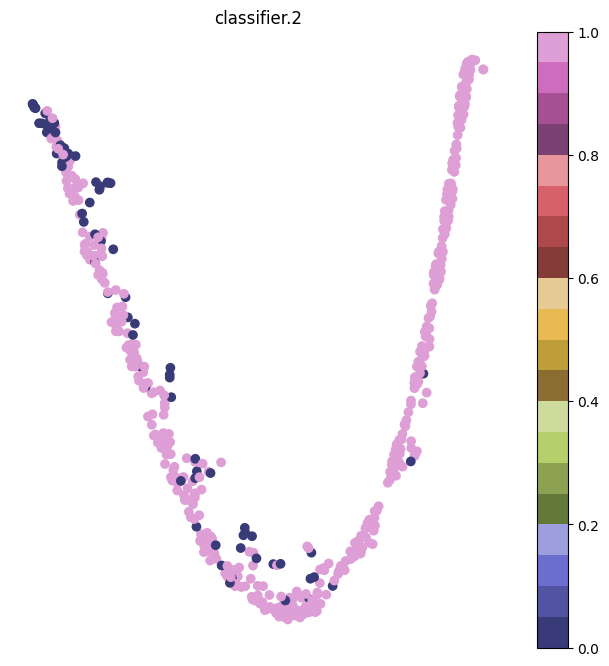

In [32]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


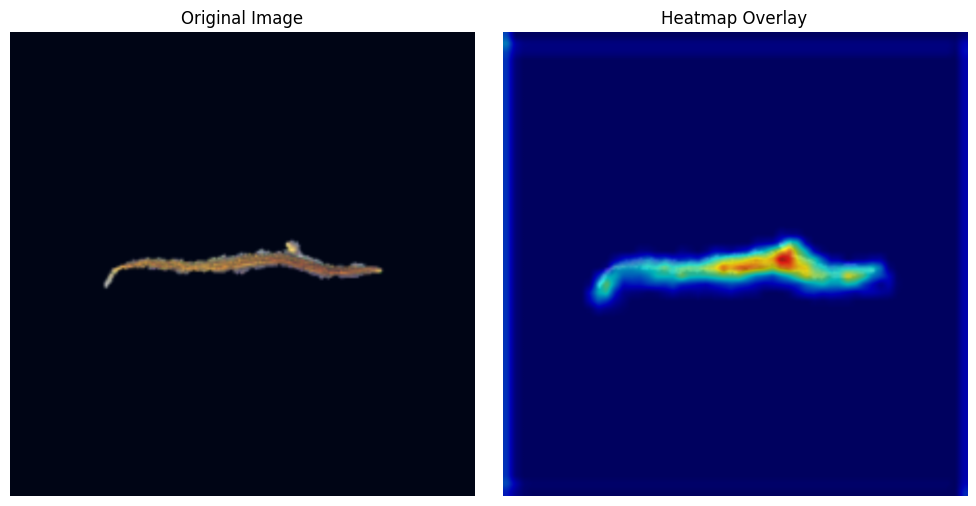

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


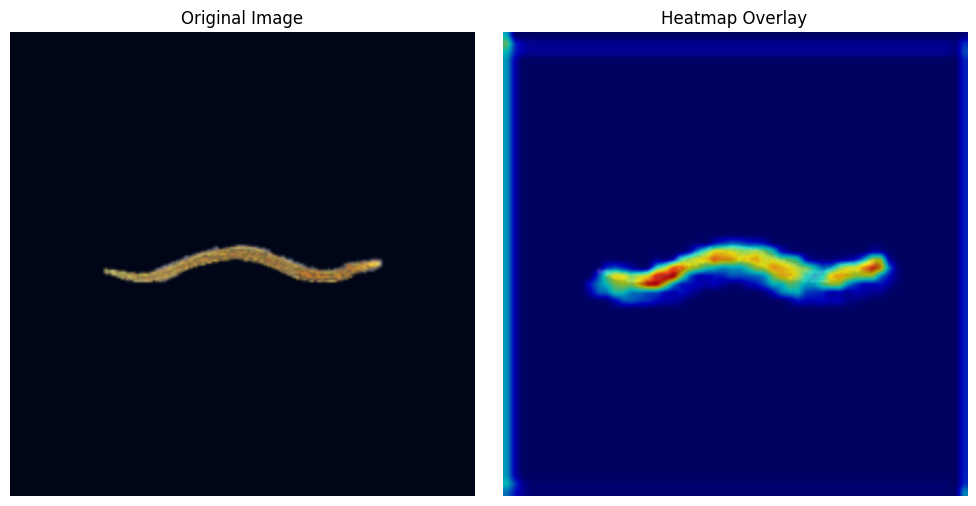

In [33]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [ ]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=eta_min)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6918 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.1541 | Val accuracy_fn: 0.1562
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6904 | Val Loss: 0.6877 | Train cohen_kappa_fn: 0.0005 | Val cohen_kappa_fn: 0.0012 | Train accuracy_fn: 0.1554 | Val accuracy_fn: 0.1594
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6817 | Val Loss: 0.6693 | Train cohen_kappa_fn: 0.1593 | Val cohen_kappa_fn: 0.1595 | Train accuracy_fn: 0.4762 | Val accuracy_fn: 0.4750
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6467 | Val Loss: 0.6155 | Train cohen_kappa_fn: 0.1036 | Val cohen_kappa_fn: 0.0678 | Train accuracy_fn: 0.3847 | Val accuracy_fn: 0.3156
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5506 | Val Loss: 0.4705 | Train cohen_kappa_fn: 0.5146 | Val cohen_kappa_fn: 0.4297 | Train accuracy_fn: 0.8145 | Val accuracy_fn: 0.7688
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4128 | Val Loss: 0.3381 | Train cohen_kappa_fn: 0.7481 | Val cohen_kappa_fn: 0.6855 | Train accuracy_fn: 0.9273 | Val accuracy_fn: 0.9062
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2902 | Val Loss: 0.2878 | Train cohen_kappa_fn: 0.6760 | Val cohen_kappa_fn: 0.6310 | Train accuracy_fn: 0.8947 | Val accuracy_fn: 0.8781
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2606 | Val Loss: 0.3579 | Train cohen_kappa_fn: 0.5022 | Val cohen_kappa_fn: 0.4344 | Train accuracy_fn: 0.8020 | Val accuracy_fn: 0.7719
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2411 | Val Loss: 0.2486 | Train cohen_kappa_fn: 0.8181 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9486 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2139 | Val Loss: 0.3421 | Train cohen_kappa_fn: 0.8179 | Val cohen_kappa_fn: 0.7570 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1894 | Val Loss: 0.3059 | Train cohen_kappa_fn: 0.9090 | Val cohen_kappa_fn: 0.7757 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1854 | Val Loss: 0.3019 | Train cohen_kappa_fn: 0.5254 | Val cohen_kappa_fn: 0.5453 | Train accuracy_fn: 0.8158 | Val accuracy_fn: 0.8313
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1887 | Val Loss: 0.2367 | Train cohen_kappa_fn: 0.8319 | Val cohen_kappa_fn: 0.8001 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9469
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1428 | Val Loss: 0.2154 | Train cohen_kappa_fn: 0.8484 | Val cohen_kappa_fn: 0.7966 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1617 | Val Loss: 0.2293 | Train cohen_kappa_fn: 0.7352 | Val cohen_kappa_fn: 0.7398 | Train accuracy_fn: 0.9160 | Val accuracy_fn: 0.9219
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1322 | Val Loss: 0.2201 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1244 | Val Loss: 0.2603 | Train cohen_kappa_fn: 0.8884 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9699 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1312 | Val Loss: 0.1856 | Train cohen_kappa_fn: 0.8155 | Val cohen_kappa_fn: 0.7519 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1250 | Val Loss: 0.2126 | Train cohen_kappa_fn: 0.8071 | Val cohen_kappa_fn: 0.7606 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9281
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1408 | Val Loss: 0.2363 | Train cohen_kappa_fn: 0.9291 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1330 | Val Loss: 0.2135 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.8208 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1314 | Val Loss: 0.2993 | Train cohen_kappa_fn: 0.9084 | Val cohen_kappa_fn: 0.7971 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1084 | Val Loss: 0.1937 | Train cohen_kappa_fn: 0.8293 | Val cohen_kappa_fn: 0.7693 | Train accuracy_fn: 0.9499 | Val accuracy_fn: 0.9312
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


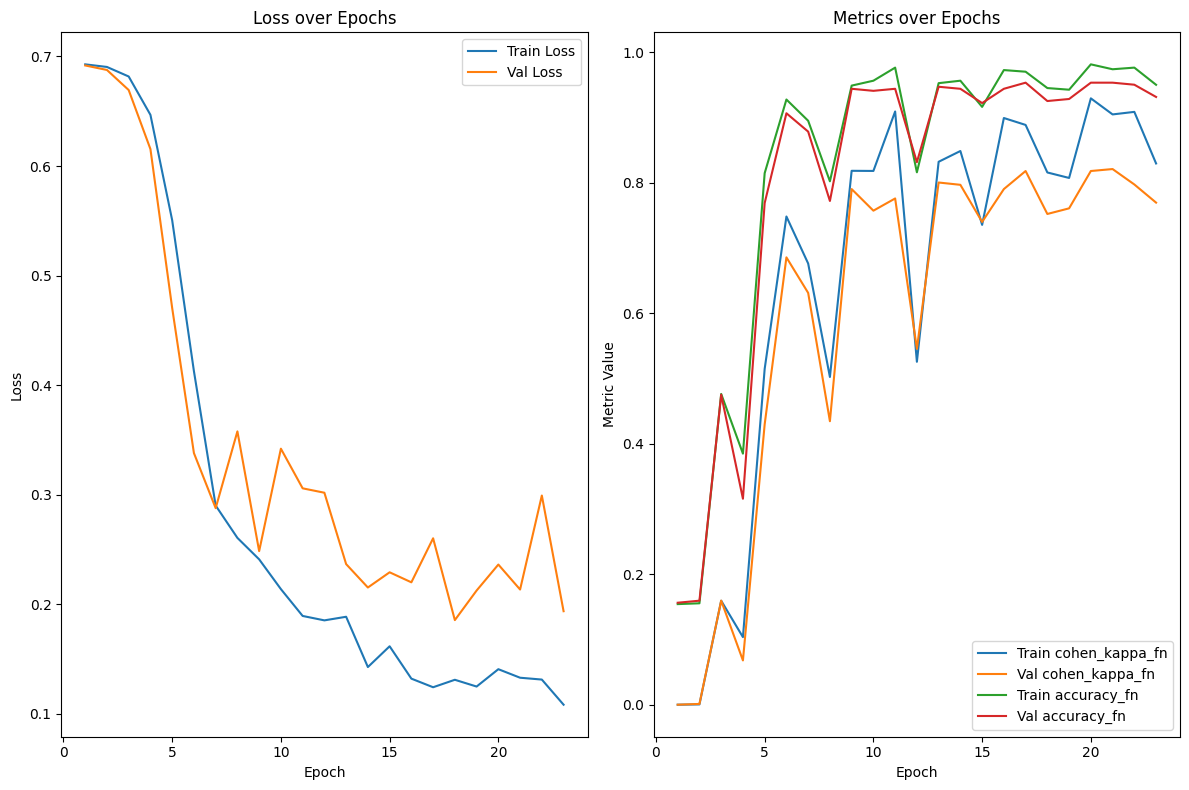

In [ ]:
trainer_cnn_3.plot_epochs()

In [ ]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1211 | Test cohen_kappa_fn: 0.8130 | Test accuracy_fn: 0.9458


#### Visualization

In [ ]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

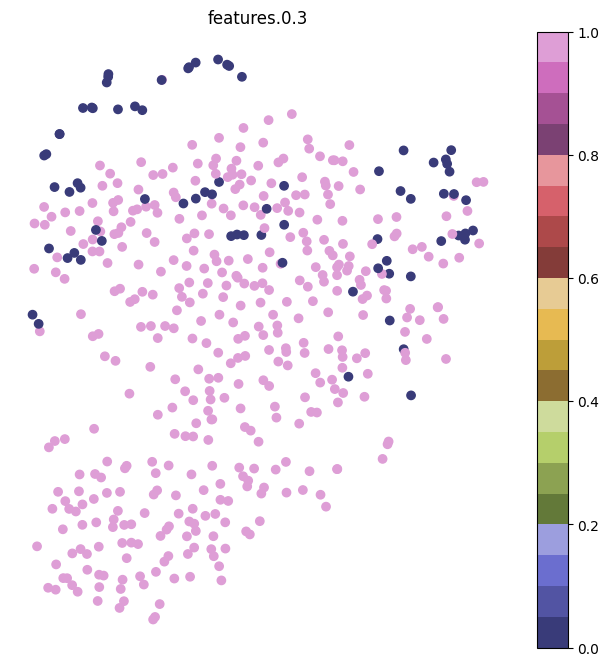

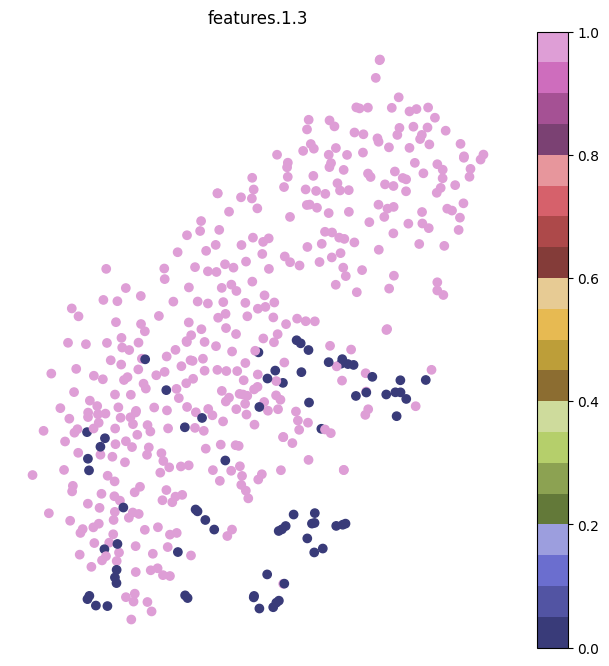

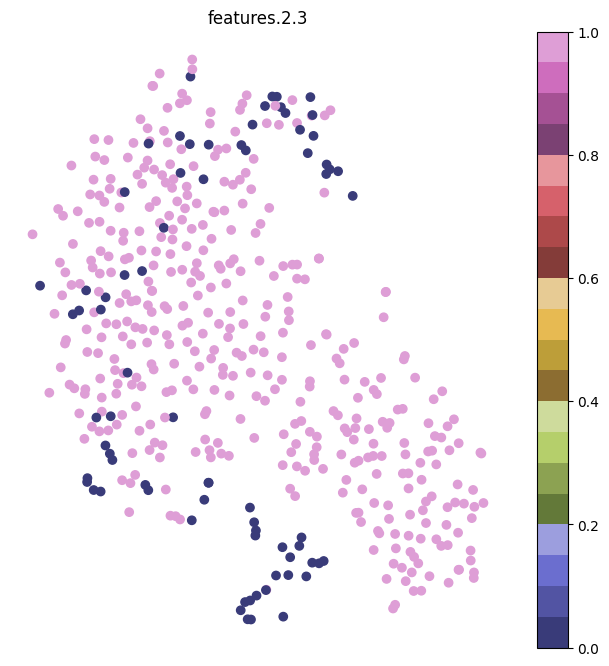

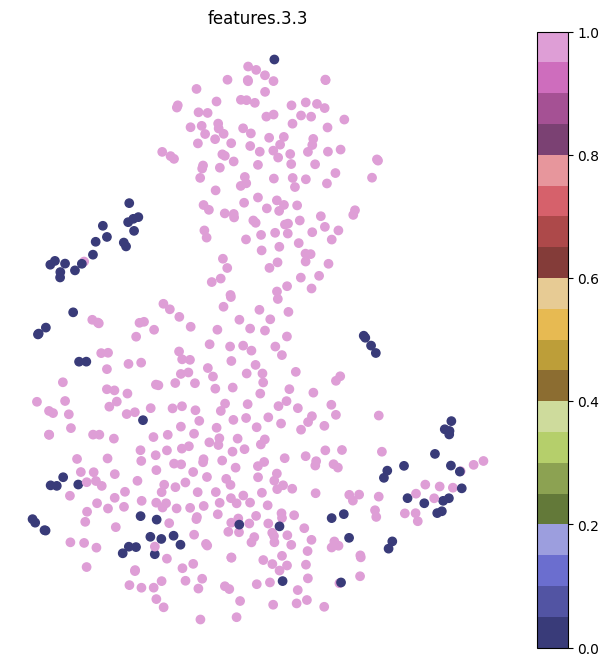

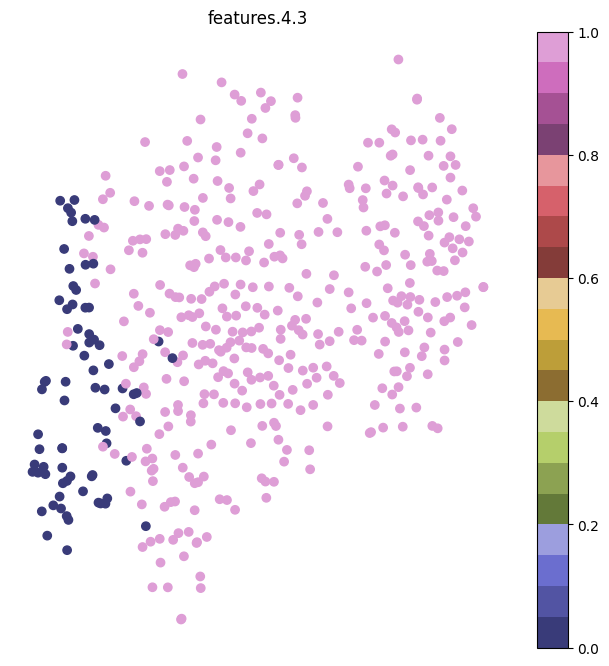

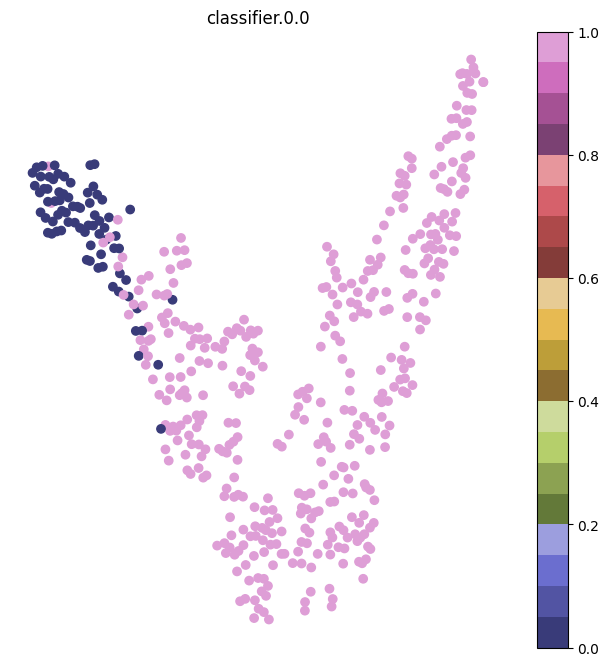

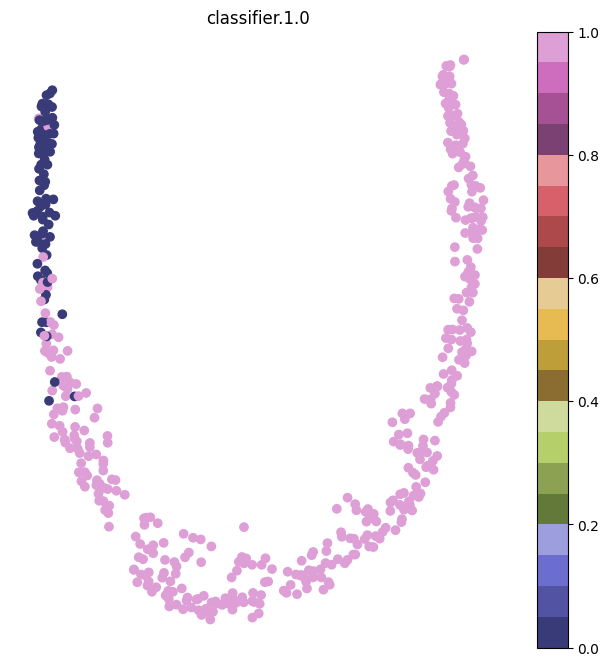

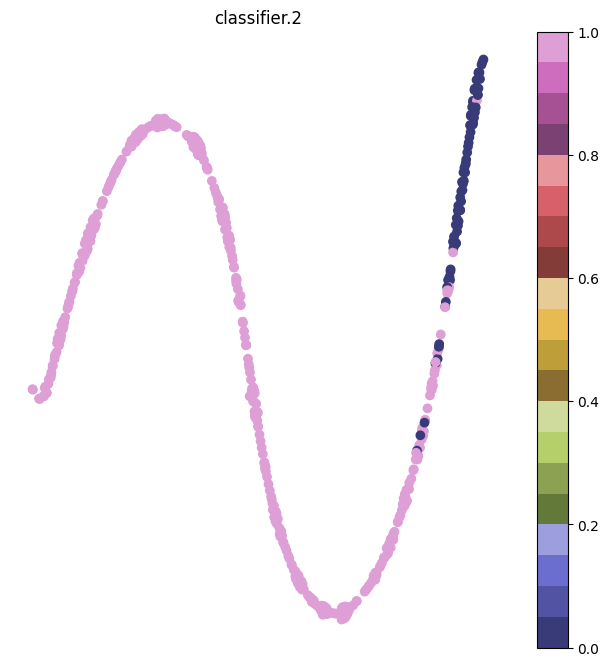

In [ ]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


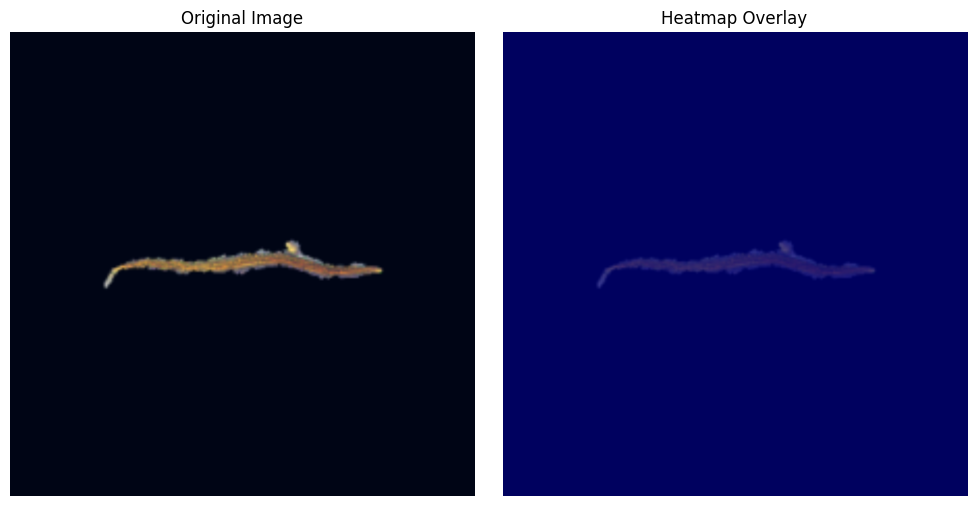

  Generating heatmap for Larvae...
  Predicted label is Larvae!


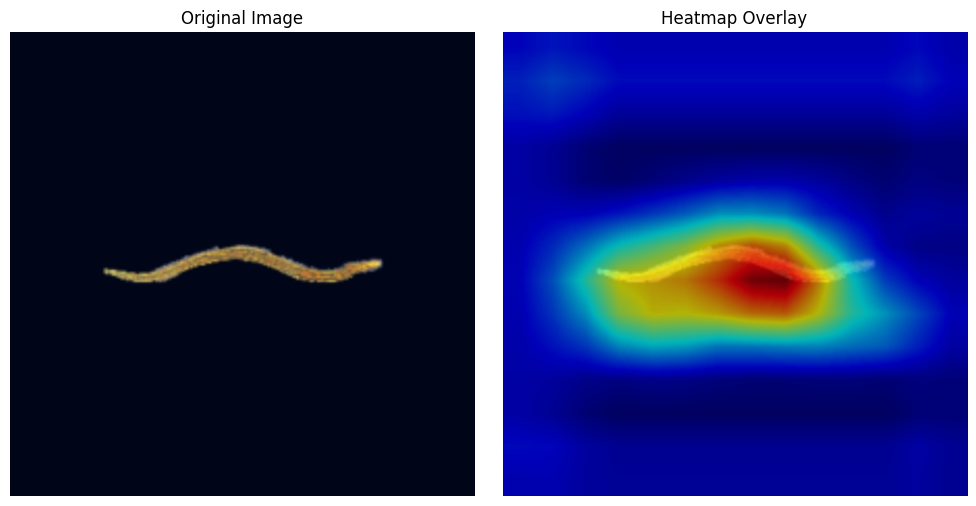

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [ ]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=eta_min)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6921 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6906 | Val Loss: 0.6857 | Train cohen_kappa_fn: 0.5090 | Val cohen_kappa_fn: 0.3517 | Train accuracy_fn: 0.8835 | Val accuracy_fn: 0.8625
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6736 | Val Loss: 0.6437 | Train cohen_kappa_fn: 0.3038 | Val cohen_kappa_fn: 0.2841 | Train accuracy_fn: 0.6754 | Val accuracy_fn: 0.6344
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5942 | Val Loss: 0.5085 | Train cohen_kappa_fn: 0.4178 | Val cohen_kappa_fn: 0.4058 | Train accuracy_fn: 0.7644 | Val accuracy_fn: 0.7437
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4370 | Val Loss: 0.3476 | Train cohen_kappa_fn: 0.5972 | Val cohen_kappa_fn: 0.5797 | Train accuracy_fn: 0.8622 | Val accuracy_fn: 0.8594
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3295 | Val Loss: 0.3232 | Train cohen_kappa_fn: 0.7927 | Val cohen_kappa_fn: 0.7419 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3010 | Val Loss: 0.2745 | Train cohen_kappa_fn: 0.6544 | Val cohen_kappa_fn: 0.6977 | Train accuracy_fn: 0.8847 | Val accuracy_fn: 0.9125
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2264 | Val Loss: 0.2698 | Train cohen_kappa_fn: 0.5018 | Val cohen_kappa_fn: 0.5837 | Train accuracy_fn: 0.8058 | Val accuracy_fn: 0.8562
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1978 | Val Loss: 0.5815 | Train cohen_kappa_fn: 0.7791 | Val cohen_kappa_fn: 0.6169 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9187
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1986 | Val Loss: 0.2068 | Train cohen_kappa_fn: 0.6384 | Val cohen_kappa_fn: 0.7498 | Train accuracy_fn: 0.8759 | Val accuracy_fn: 0.9281
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1816 | Val Loss: 0.2663 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.8040 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1494 | Val Loss: 0.2337 | Train cohen_kappa_fn: 0.7407 | Val cohen_kappa_fn: 0.8104 | Train accuracy_fn: 0.9198 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1442 | Val Loss: 0.3972 | Train cohen_kappa_fn: 0.8636 | Val cohen_kappa_fn: 0.6775 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9281
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1370 | Val Loss: 0.2233 | Train cohen_kappa_fn: 0.8821 | Val cohen_kappa_fn: 0.8530 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9625
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1477 | Val Loss: 0.3404 | Train cohen_kappa_fn: 0.8654 | Val cohen_kappa_fn: 0.8115 | Train accuracy_fn: 0.9649 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


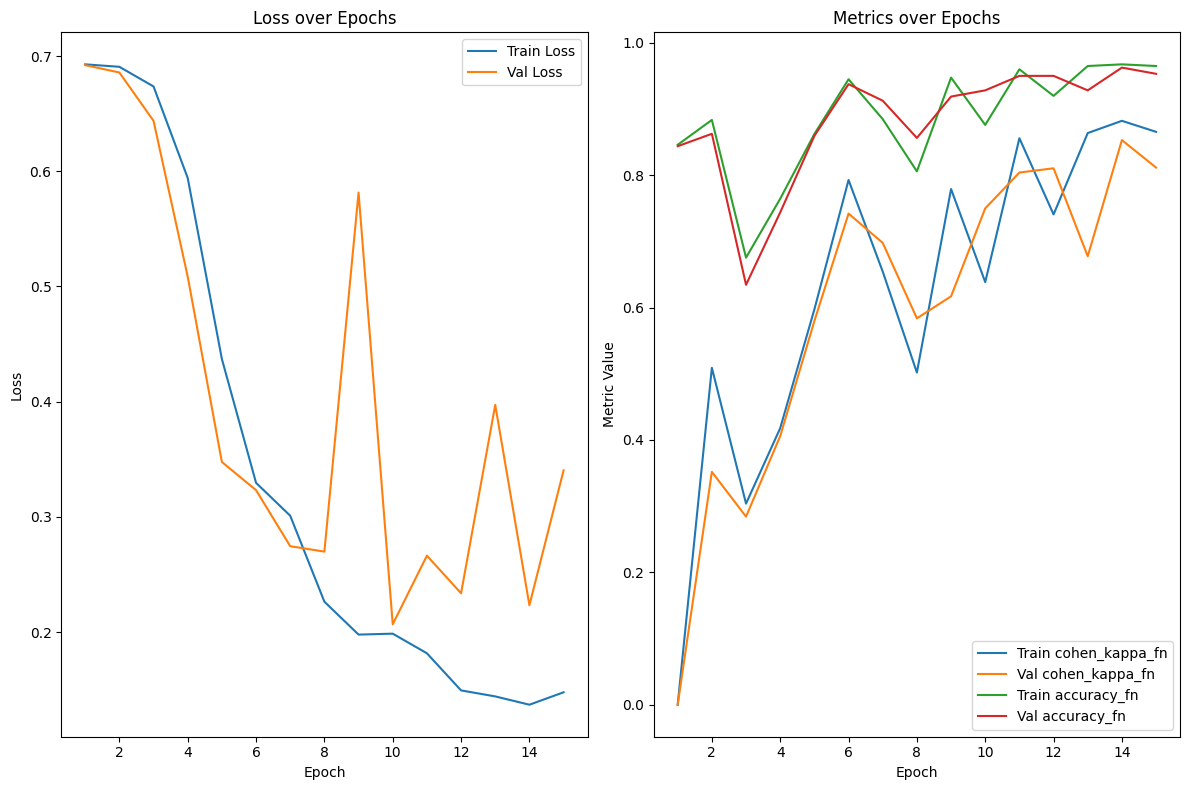

In [ ]:
trainer_cnn_4.plot_epochs()

In [ ]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1756 | Test cohen_kappa_fn: 0.8174 | Test accuracy_fn: 0.9479


#### Visualization

In [ ]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

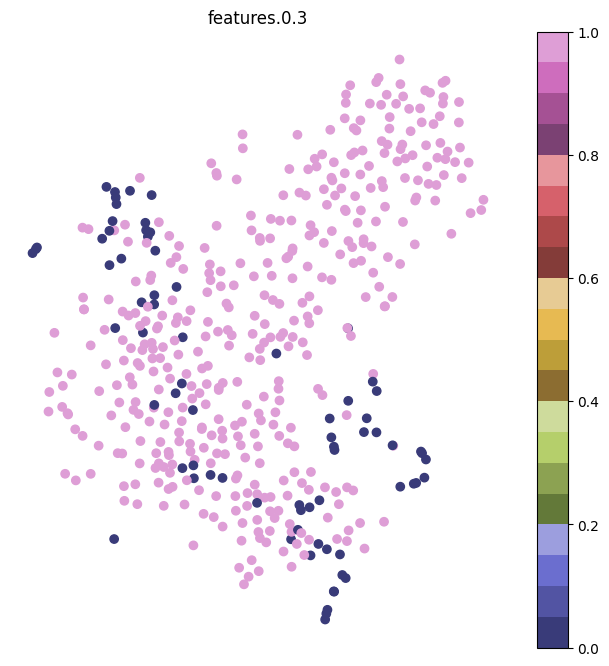

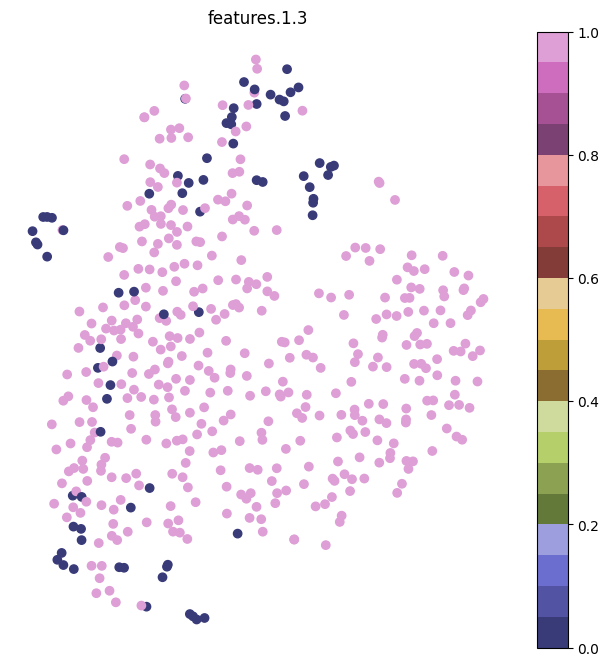

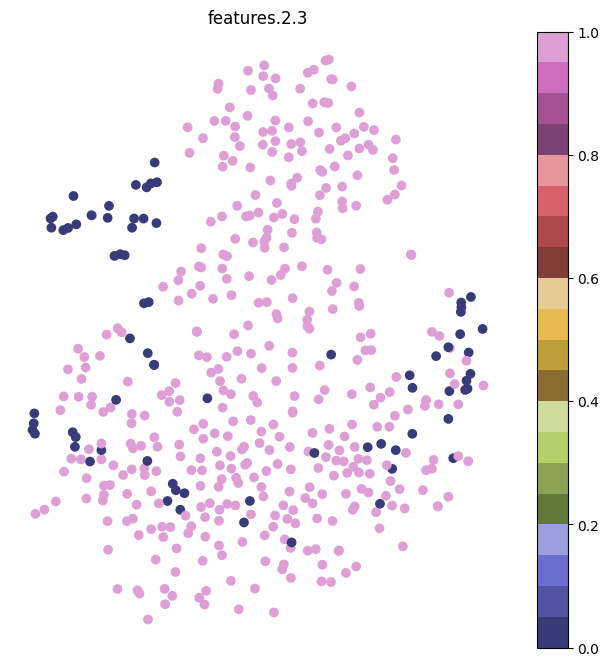

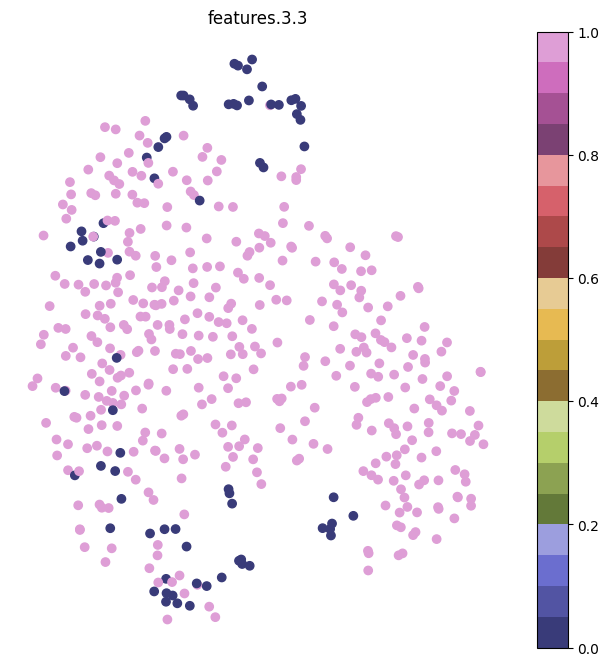

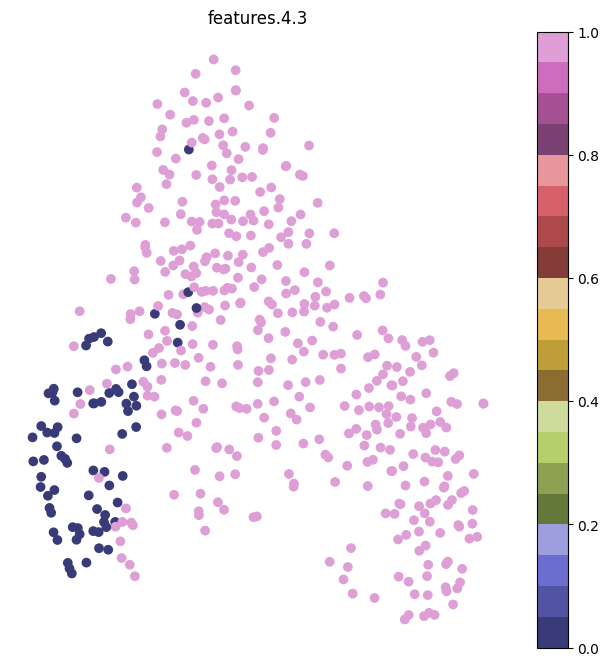

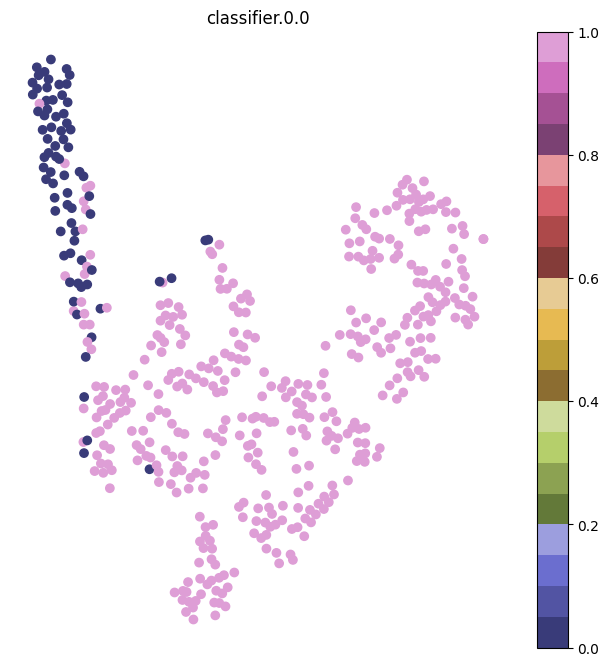

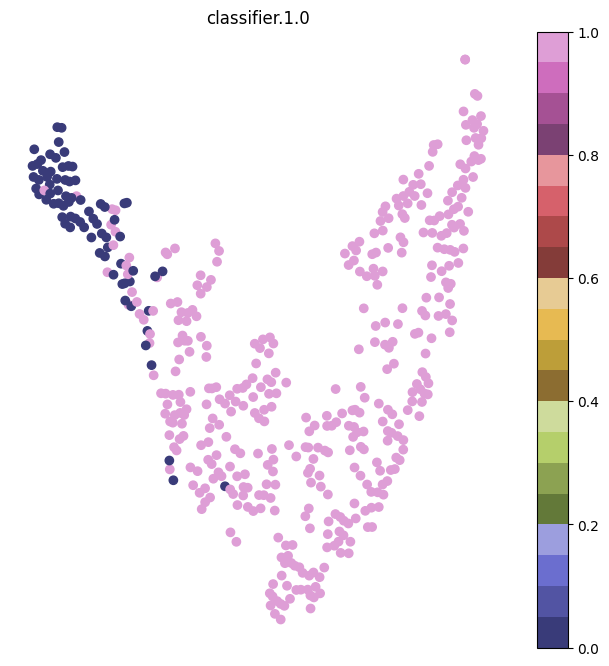

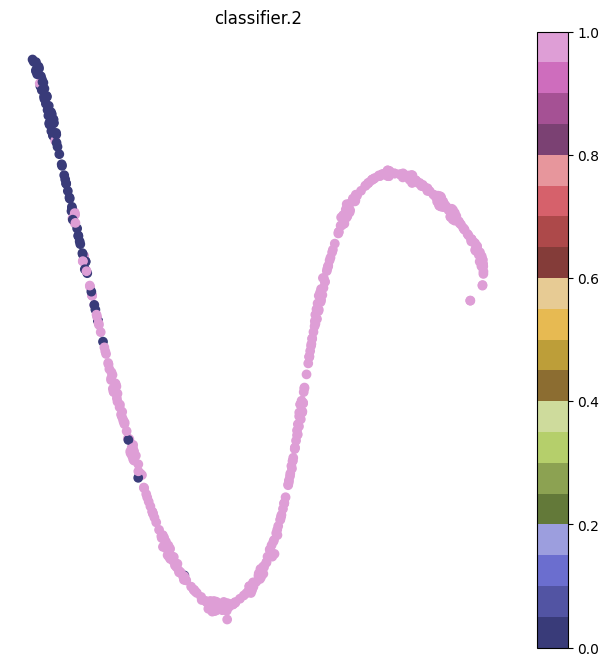

In [ ]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


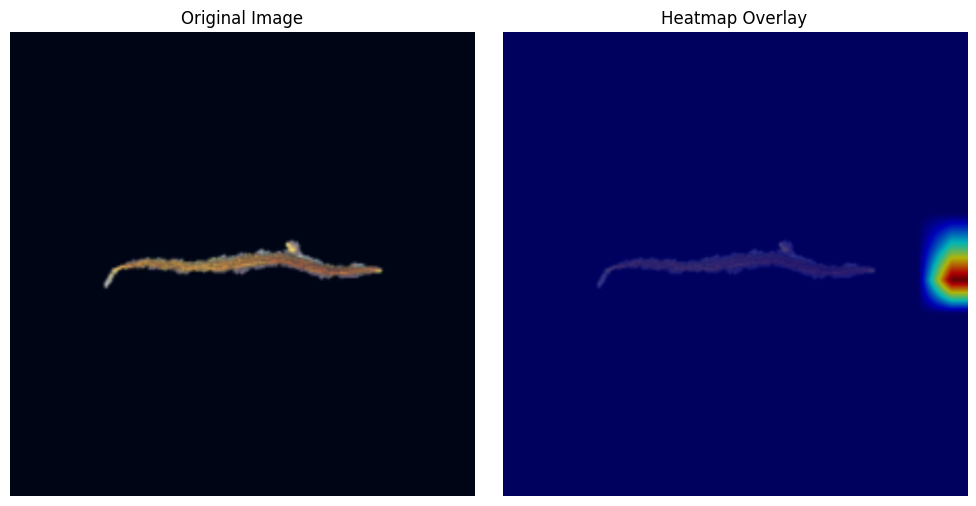

  Generating heatmap for Larvae...
  Predicted label is Larvae!


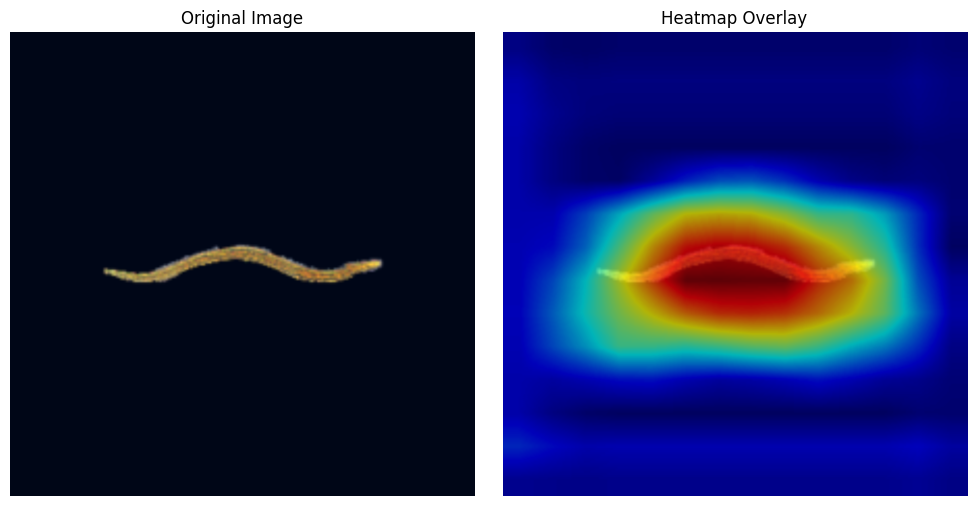

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [ ]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=eta_min)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6919 | Val Loss: 0.6902 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6850 | Val Loss: 0.6769 | Train cohen_kappa_fn: 0.3203 | Val cohen_kappa_fn: 0.3294 | Train accuracy_fn: 0.7055 | Val accuracy_fn: 0.7094
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6527 | Val Loss: 0.6113 | Train cohen_kappa_fn: 0.3527 | Val cohen_kappa_fn: 0.3526 | Train accuracy_fn: 0.7431 | Val accuracy_fn: 0.7375
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5673 | Val Loss: 0.4945 | Train cohen_kappa_fn: 0.3638 | Val cohen_kappa_fn: 0.3748 | Train accuracy_fn: 0.7293 | Val accuracy_fn: 0.7156
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4357 | Val Loss: 0.5932 | Train cohen_kappa_fn: 0.1406 | Val cohen_kappa_fn: 0.0868 | Train accuracy_fn: 0.4474 | Val accuracy_fn: 0.3531
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.3518 | Val Loss: 0.2776 | Train cohen_kappa_fn: 0.7148 | Val cohen_kappa_fn: 0.6899 | Train accuracy_fn: 0.9135 | Val accuracy_fn: 0.9062
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2691 | Val Loss: 0.2748 | Train cohen_kappa_fn: 0.6026 | Val cohen_kappa_fn: 0.5699 | Train accuracy_fn: 0.8609 | Val accuracy_fn: 0.8469
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2574 | Val Loss: 0.2350 | Train cohen_kappa_fn: 0.8419 | Val cohen_kappa_fn: 0.7795 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2381 | Val Loss: 0.2709 | Train cohen_kappa_fn: 0.5105 | Val cohen_kappa_fn: 0.5387 | Train accuracy_fn: 0.8083 | Val accuracy_fn: 0.8219
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1948 | Val Loss: 0.1967 | Train cohen_kappa_fn: 0.8319 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9531
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1846 | Val Loss: 0.1978 | Train cohen_kappa_fn: 0.8060 | Val cohen_kappa_fn: 0.7997 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1685 | Val Loss: 0.1901 | Train cohen_kappa_fn: 0.8814 | Val cohen_kappa_fn: 0.8255 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9563
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1373 | Val Loss: 0.2629 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1366 | Val Loss: 0.1696 | Train cohen_kappa_fn: 0.8026 | Val cohen_kappa_fn: 0.8367 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9563
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1423 | Val Loss: 0.5390 | Train cohen_kappa_fn: 0.2232 | Val cohen_kappa_fn: 0.2932 | Train accuracy_fn: 0.5652 | Val accuracy_fn: 0.6375
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1453 | Val Loss: 0.2891 | Train cohen_kappa_fn: 0.8936 | Val cohen_kappa_fn: 0.8082 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1103 | Val Loss: 0.1577 | Train cohen_kappa_fn: 0.8071 | Val cohen_kappa_fn: 0.8367 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9563
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1102 | Val Loss: 0.4312 | Train cohen_kappa_fn: 0.9013 | Val cohen_kappa_fn: 0.7324 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1061 | Val Loss: 0.3198 | Train cohen_kappa_fn: 0.9282 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1035 | Val Loss: 0.3791 | Train cohen_kappa_fn: 0.3767 | Val cohen_kappa_fn: 0.3966 | Train accuracy_fn: 0.7143 | Val accuracy_fn: 0.7281
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1165 | Val Loss: 0.7051 | Train cohen_kappa_fn: 0.7986 | Val cohen_kappa_fn: 0.5290 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9031
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1319 | Val Loss: 0.2000 | Train cohen_kappa_fn: 0.6541 | Val cohen_kappa_fn: 0.6731 | Train accuracy_fn: 0.8822 | Val accuracy_fn: 0.8906
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


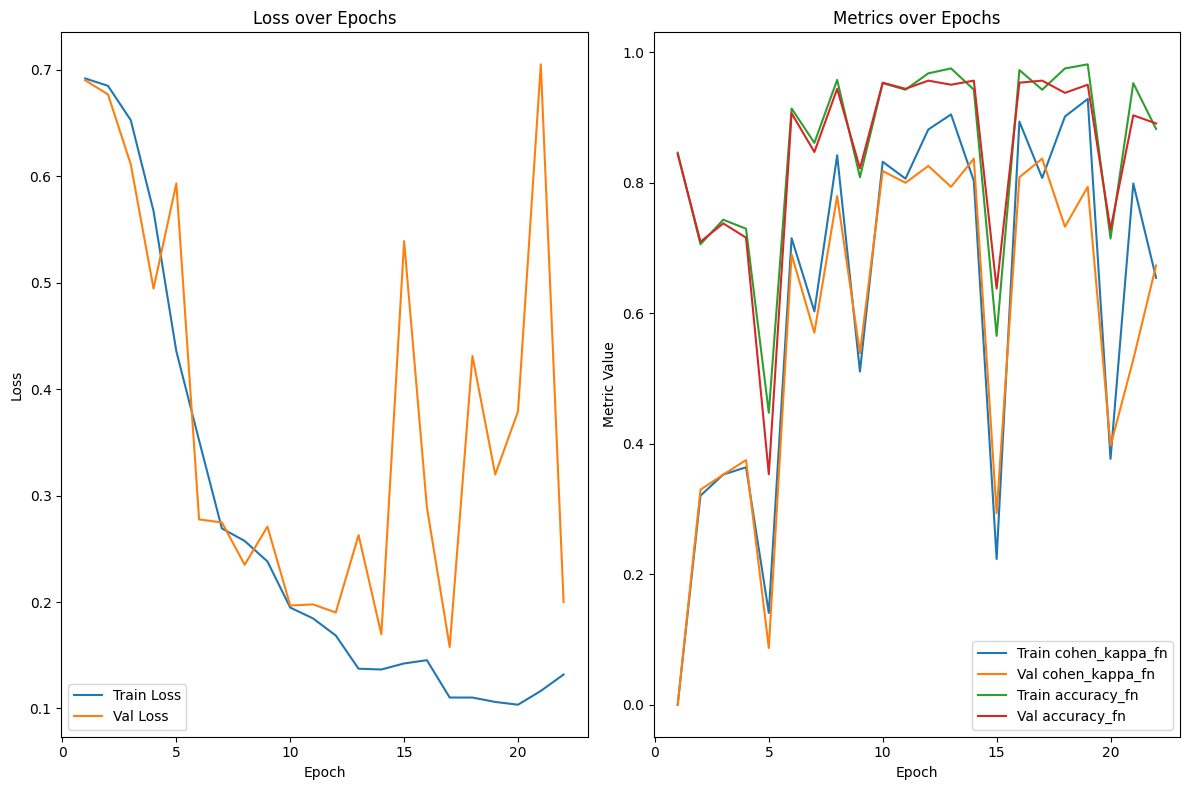

In [ ]:
trainer_cnn_5.plot_epochs()

In [ ]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1556 | Test cohen_kappa_fn: 0.8776 | Test accuracy_fn: 0.9667


#### Visualization

In [ ]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

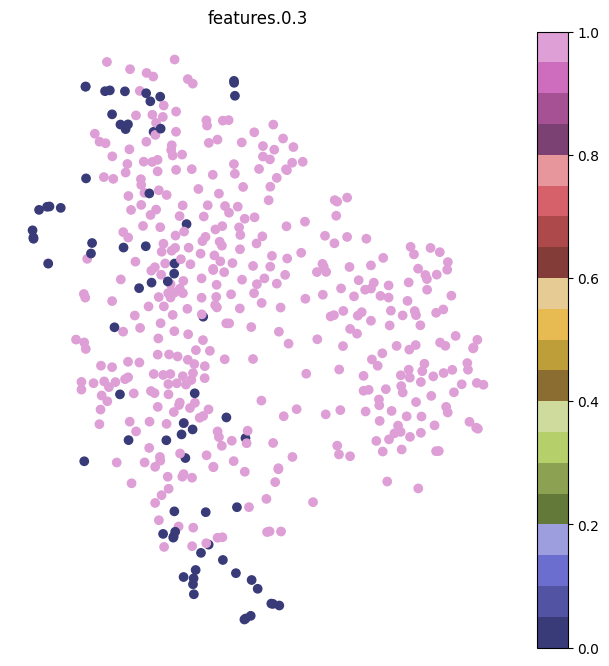

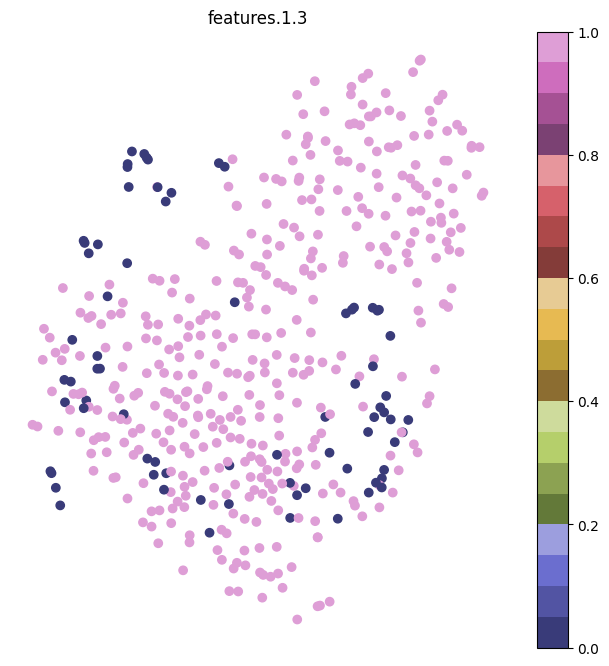

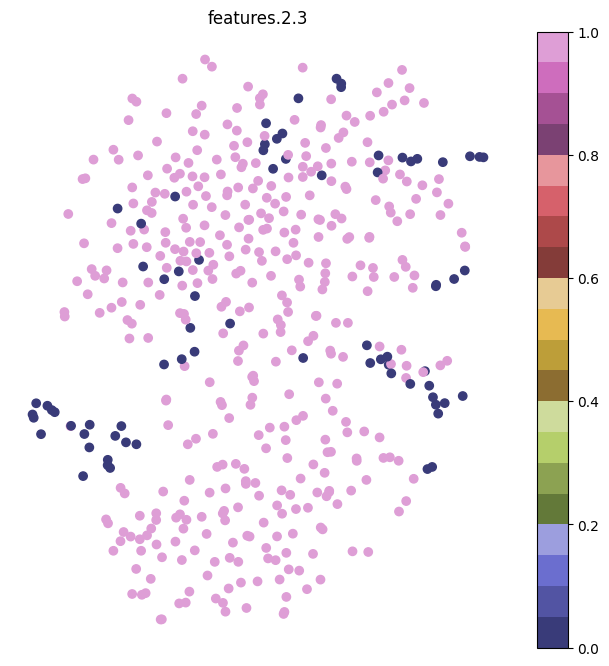

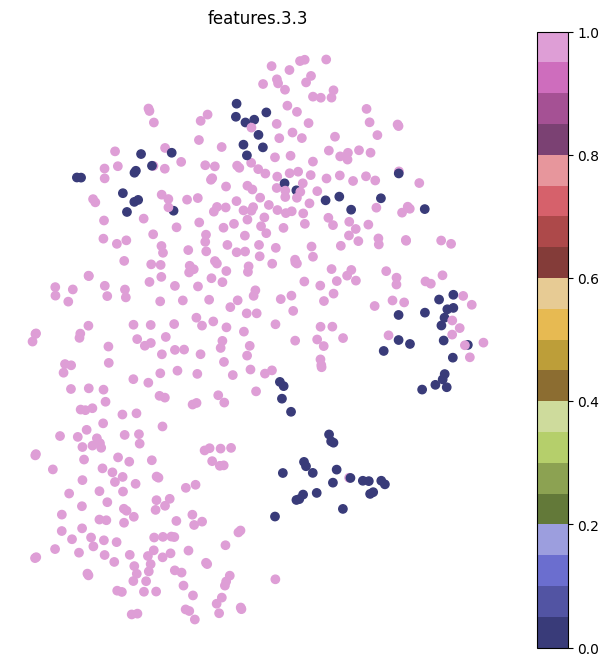

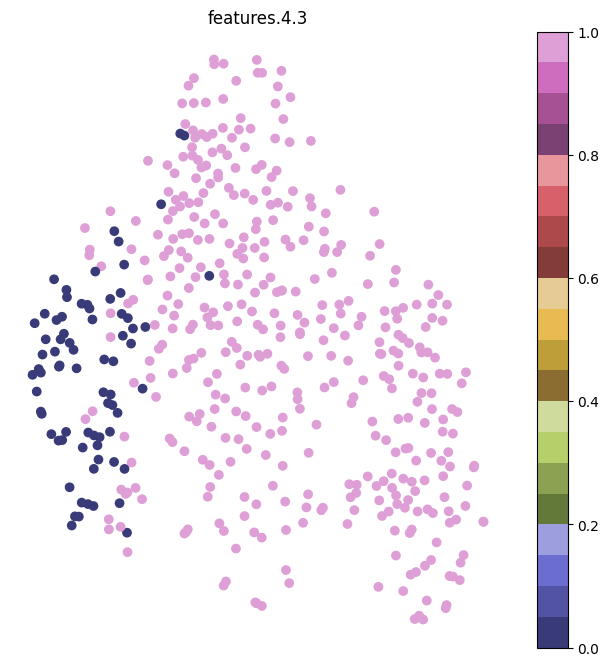

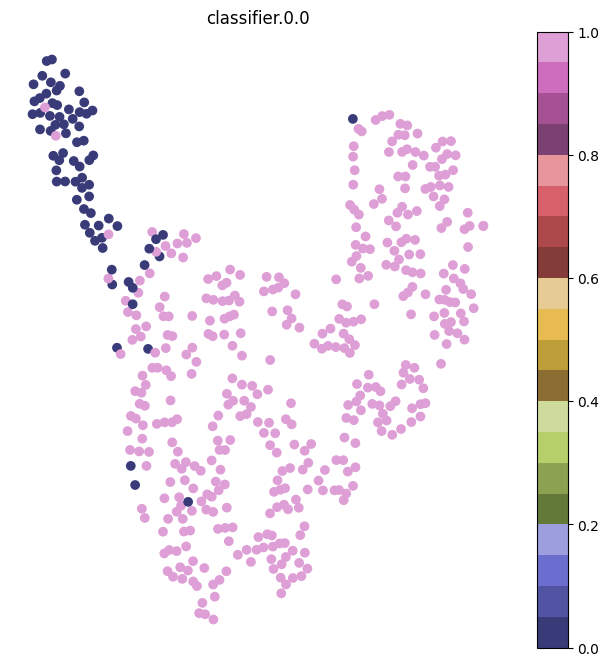

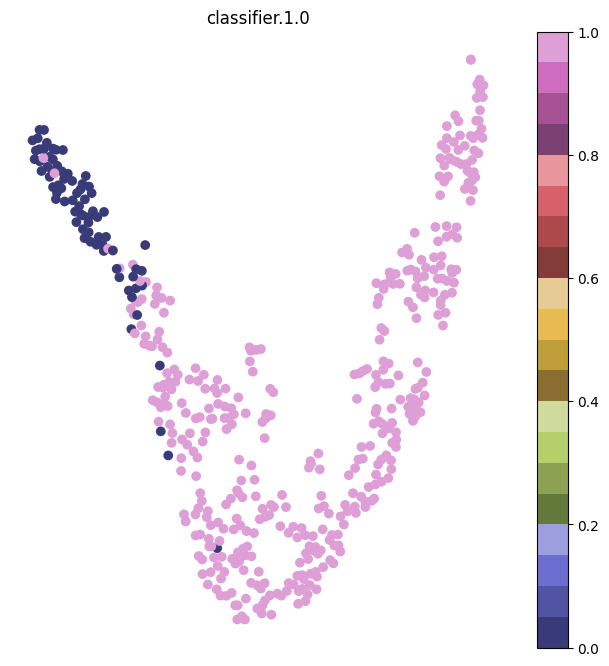

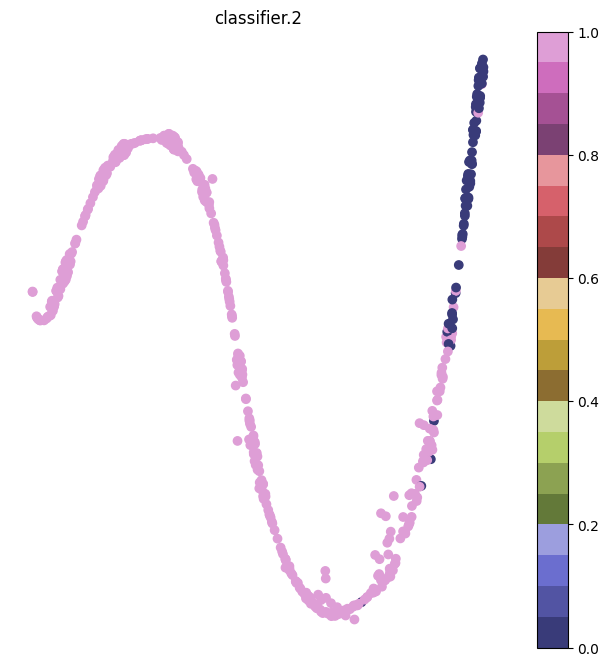

In [ ]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


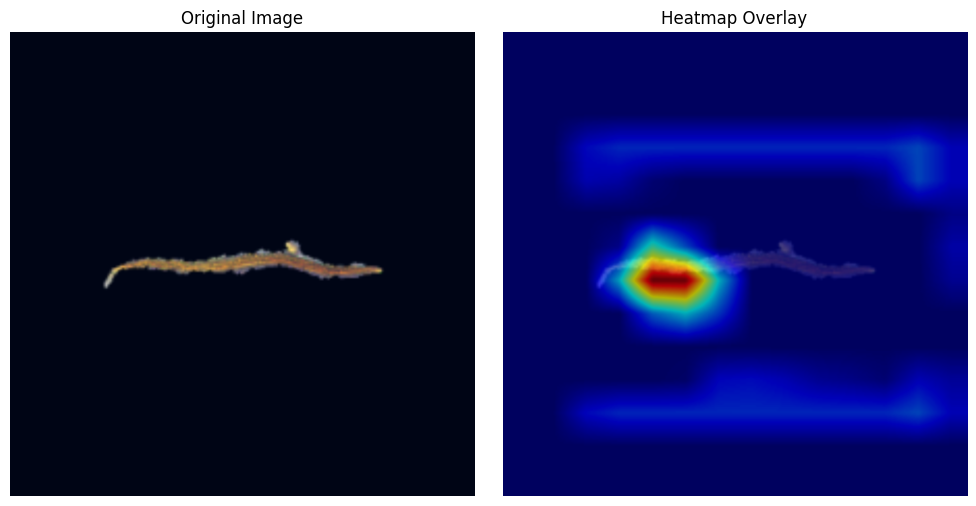

  Generating heatmap for Larvae...
  Predicted label is Larvae!


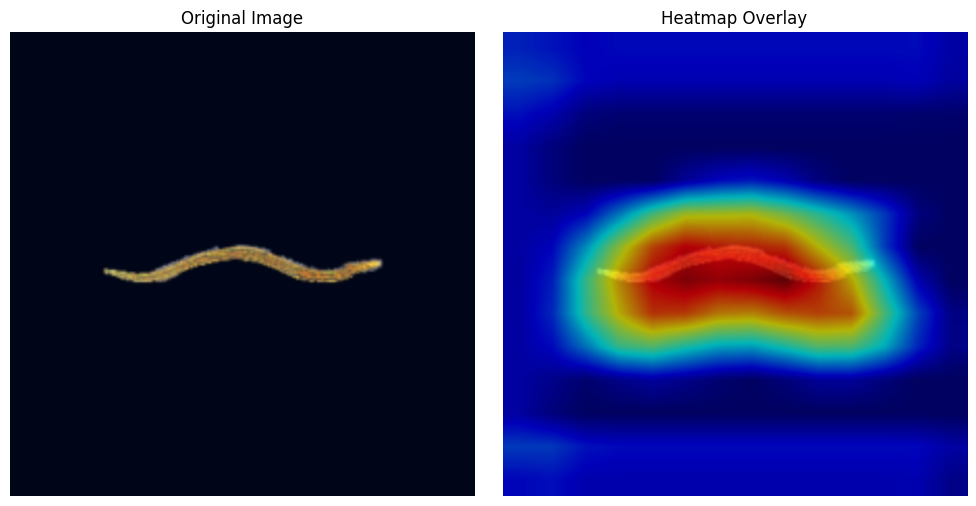

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [ ]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=eta_min)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6921 | Val Loss: 0.6903 | Train cohen_kappa_fn: 0.1219 | Val cohen_kappa_fn: -0.0122 | Train accuracy_fn: 0.8045 | Val accuracy_fn: 0.8375
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6835 | Val Loss: 0.6740 | Train cohen_kappa_fn: 0.3833 | Val cohen_kappa_fn: 0.2157 | Train accuracy_fn: 0.8296 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6537 | Val Loss: 0.6103 | Train cohen_kappa_fn: 0.4208 | Val cohen_kappa_fn: 0.3980 | Train accuracy_fn: 0.7982 | Val accuracy_fn: 0.8219
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5534 | Val Loss: 0.5252 | Train cohen_kappa_fn: 0.2038 | Val cohen_kappa_fn: 0.2014 | Train accuracy_fn: 0.5501 | Val accuracy_fn: 0.5406
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4354 | Val Loss: 0.4991 | Train cohen_kappa_fn: 0.2313 | Val cohen_kappa_fn: 0.1813 | Train accuracy_fn: 0.5777 | Val accuracy_fn: 0.5063
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3506 | Val Loss: 0.2935 | Train cohen_kappa_fn: 0.6179 | Val cohen_kappa_fn: 0.6225 | Train accuracy_fn: 0.8772 | Val accuracy_fn: 0.8875
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3180 | Val Loss: 0.3041 | Train cohen_kappa_fn: 0.5420 | Val cohen_kappa_fn: 0.6053 | Train accuracy_fn: 0.8333 | Val accuracy_fn: 0.8781
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.2614 | Val Loss: 0.2741 | Train cohen_kappa_fn: 0.7215 | Val cohen_kappa_fn: 0.7590 | Train accuracy_fn: 0.9160 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.2508 | Val Loss: 0.2732 | Train cohen_kappa_fn: 0.7420 | Val cohen_kappa_fn: 0.7531 | Train accuracy_fn: 0.9236 | Val accuracy_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2310 | Val Loss: 0.2867 | Train cohen_kappa_fn: 0.7674 | Val cohen_kappa_fn: 0.7630 | Train accuracy_fn: 0.9311 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1951 | Val Loss: 0.2830 | Train cohen_kappa_fn: 0.7568 | Val cohen_kappa_fn: 0.7245 | Train accuracy_fn: 0.9273 | Val accuracy_fn: 0.9250
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1949 | Val Loss: 0.3334 | Train cohen_kappa_fn: 0.8605 | Val cohen_kappa_fn: 0.7757 | Train accuracy_fn: 0.9624 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1936 | Val Loss: 0.2430 | Train cohen_kappa_fn: 0.6665 | Val cohen_kappa_fn: 0.6357 | Train accuracy_fn: 0.8885 | Val accuracy_fn: 0.8844
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1713 | Val Loss: 0.2367 | Train cohen_kappa_fn: 0.7455 | Val cohen_kappa_fn: 0.7704 | Train accuracy_fn: 0.9211 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1644 | Val Loss: 0.2915 | Train cohen_kappa_fn: 0.8640 | Val cohen_kappa_fn: 0.7653 | Train accuracy_fn: 0.9624 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1503 | Val Loss: 0.4146 | Train cohen_kappa_fn: 0.9058 | Val cohen_kappa_fn: 0.7373 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1422 | Val Loss: 0.3007 | Train cohen_kappa_fn: 0.8863 | Val cohen_kappa_fn: 0.7508 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1279 | Val Loss: 0.2119 | Train cohen_kappa_fn: 0.7417 | Val cohen_kappa_fn: 0.7409 | Train accuracy_fn: 0.9185 | Val accuracy_fn: 0.9250
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1433 | Val Loss: 0.2608 | Train cohen_kappa_fn: 0.8590 | Val cohen_kappa_fn: 0.7935 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1248 | Val Loss: 0.2490 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7831 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1282 | Val Loss: 0.3285 | Train cohen_kappa_fn: 0.8863 | Val cohen_kappa_fn: 0.7826 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.0984 | Val Loss: 0.2219 | Train cohen_kappa_fn: 0.8455 | Val cohen_kappa_fn: 0.8208 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1302 | Val Loss: 0.1991 | Train cohen_kappa_fn: 0.7787 | Val cohen_kappa_fn: 0.7775 | Train accuracy_fn: 0.9323 | Val accuracy_fn: 0.9375
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1259 | Val Loss: 0.1780 | Train cohen_kappa_fn: 0.7697 | Val cohen_kappa_fn: 0.7902 | Train accuracy_fn: 0.9286 | Val accuracy_fn: 0.9406
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.0938 | Val Loss: 0.3844 | Train cohen_kappa_fn: 0.9332 | Val cohen_kappa_fn: 0.7677 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.0822 | Val Loss: 0.1827 | Train cohen_kappa_fn: 0.8417 | Val cohen_kappa_fn: 0.8094 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.0866 | Val Loss: 0.2071 | Train cohen_kappa_fn: 0.8545 | Val cohen_kappa_fn: 0.7901 | Train accuracy_fn: 0.9586 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.0909 | Val Loss: 0.2547 | Train cohen_kappa_fn: 0.9099 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9749 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.0959 | Val Loss: 0.3562 | Train cohen_kappa_fn: 0.8983 | Val cohen_kappa_fn: 0.7677 | Train accuracy_fn: 0.9724 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


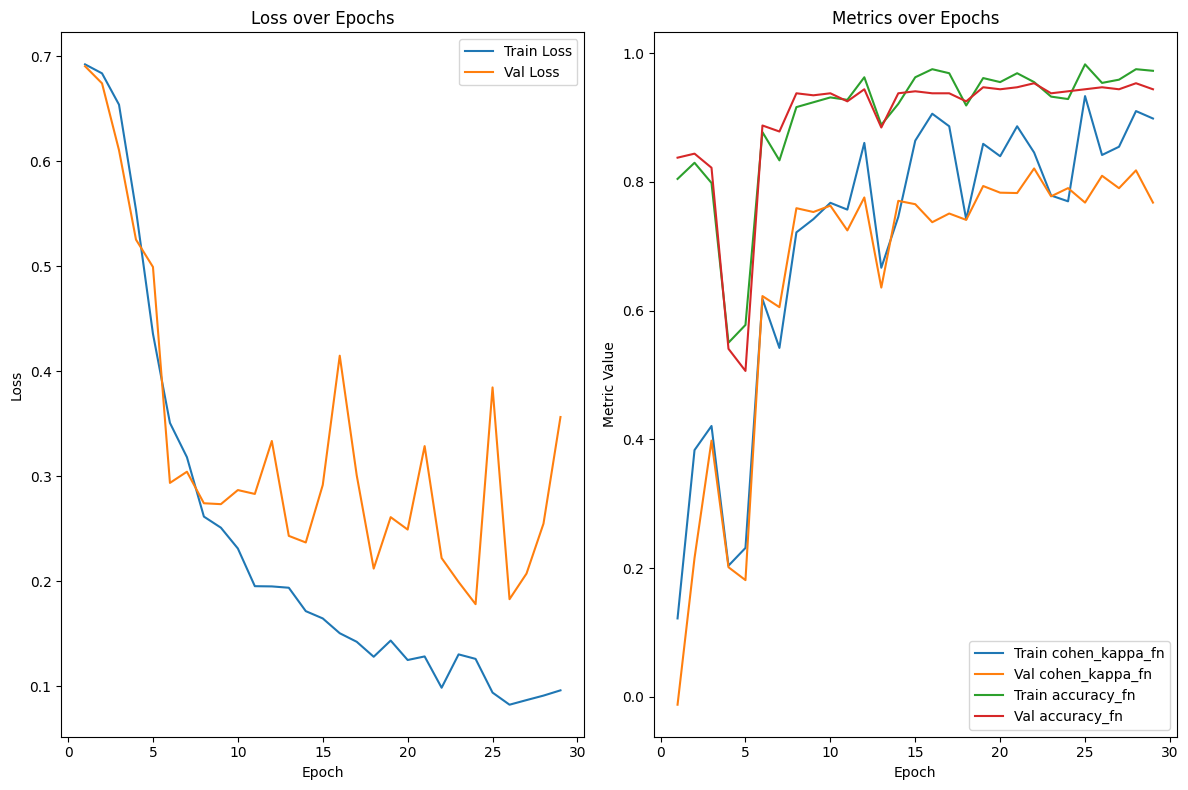

In [ ]:
trainer_cnn_6.plot_epochs()

In [ ]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1837 | Test cohen_kappa_fn: 0.7426 | Test accuracy_fn: 0.9292


#### Visualization

In [ ]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

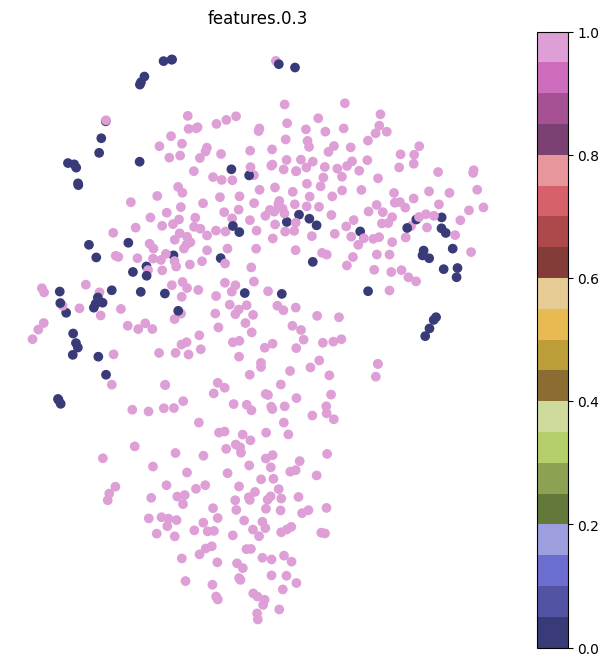

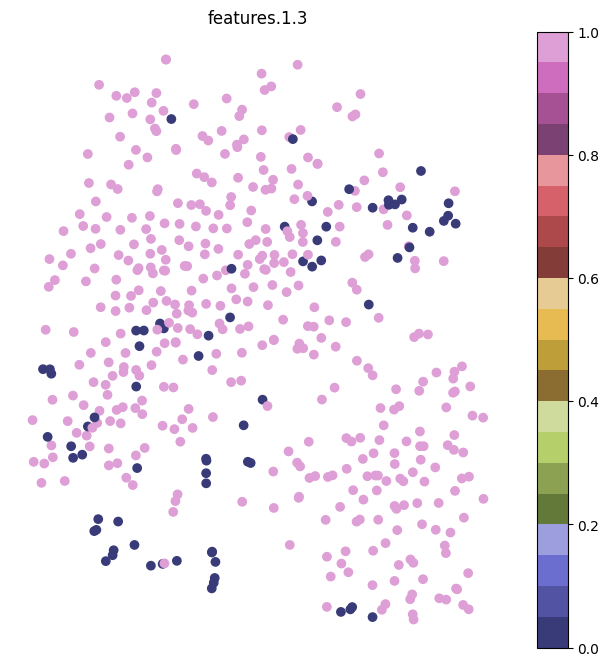

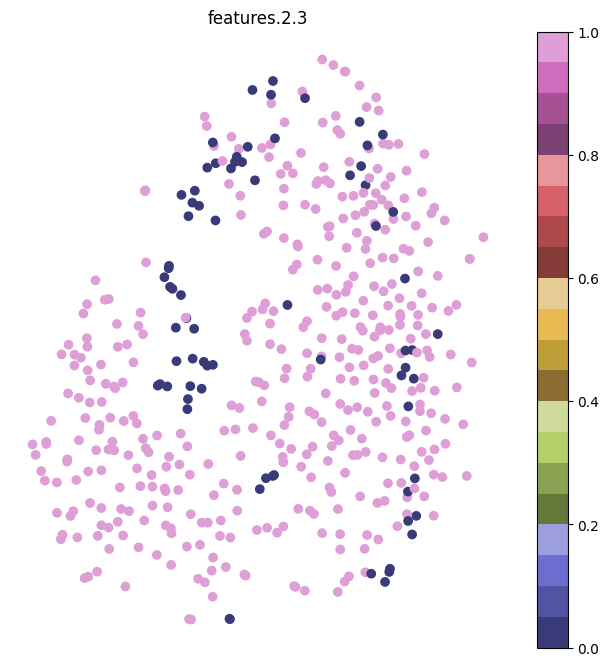

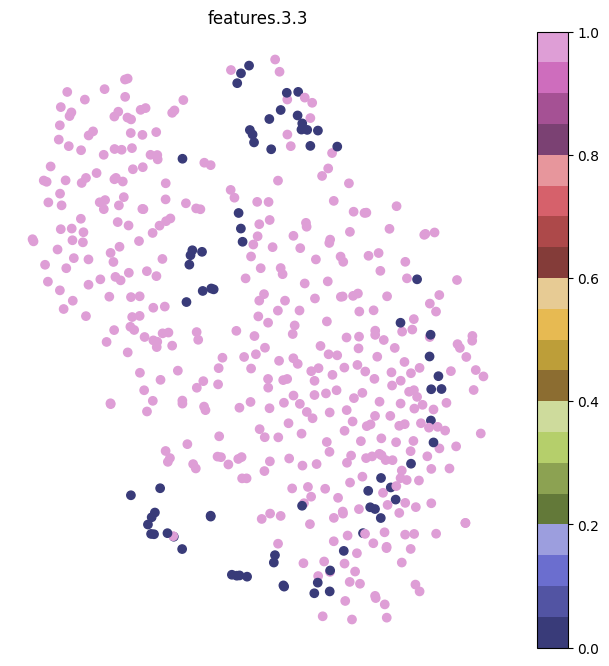

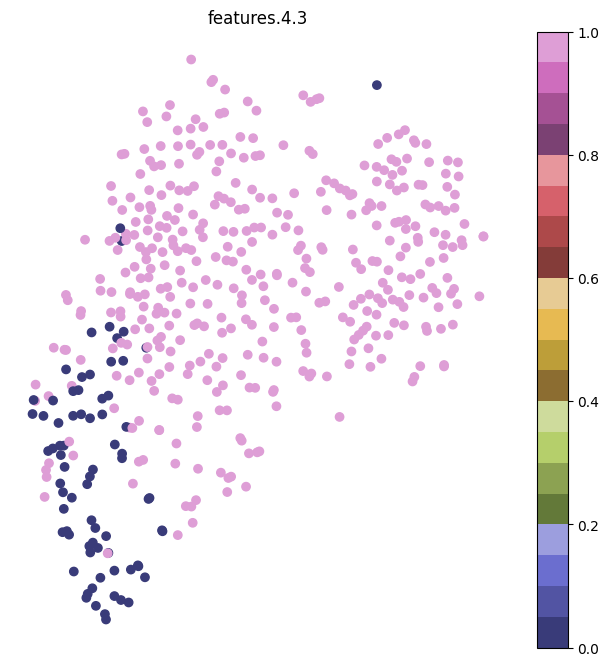

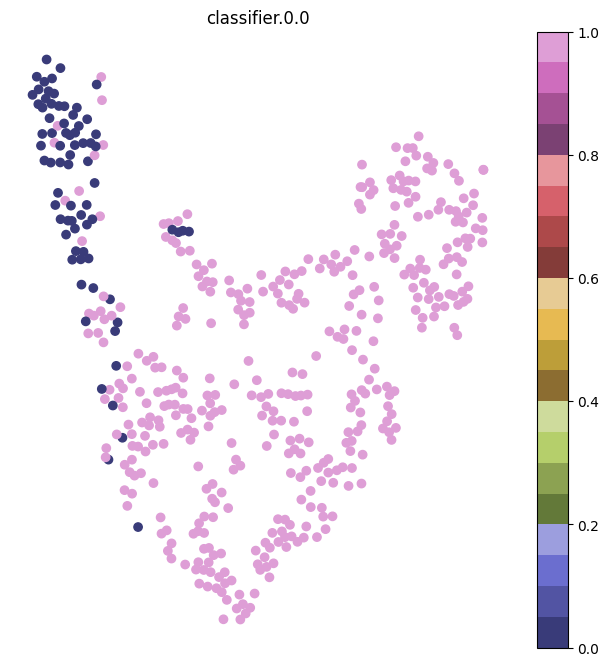

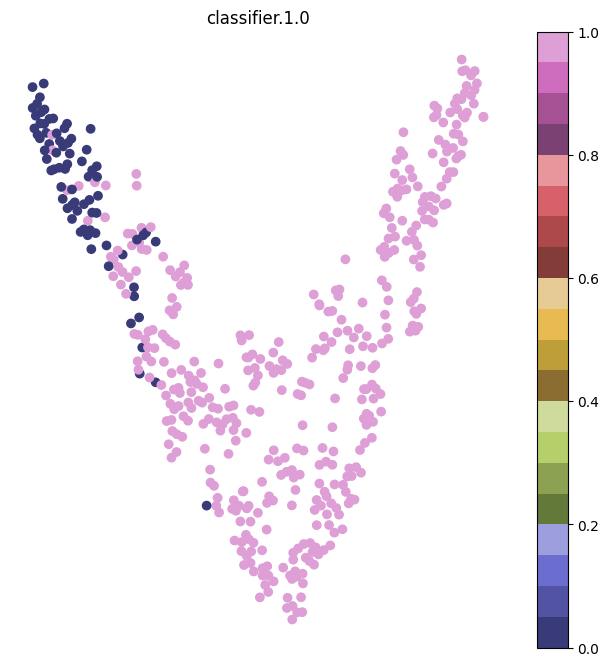

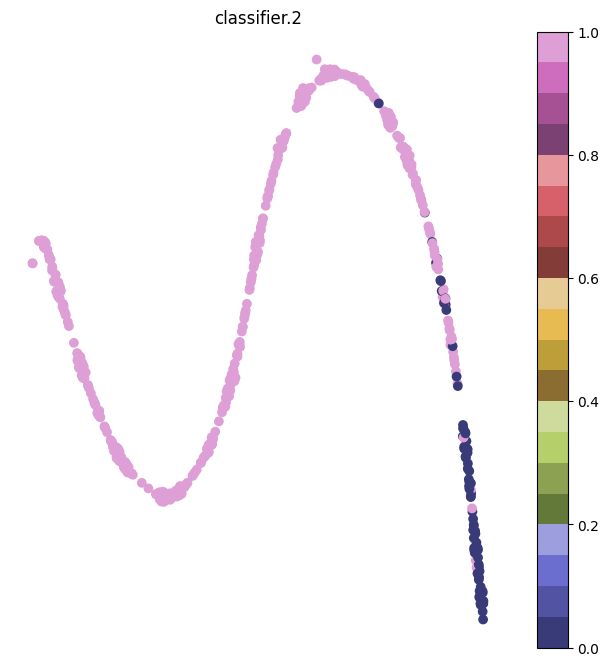

In [ ]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


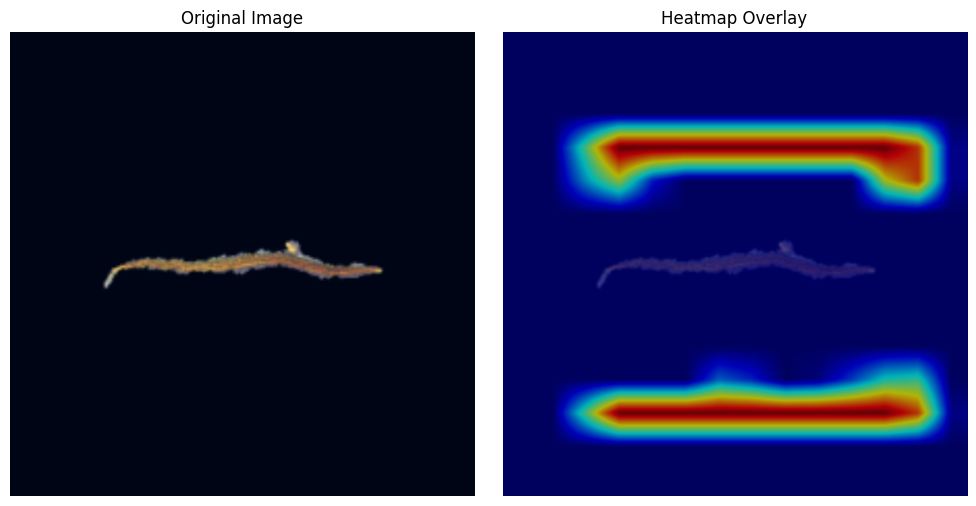

  Generating heatmap for Larvae...
  Predicted label is Larvae!


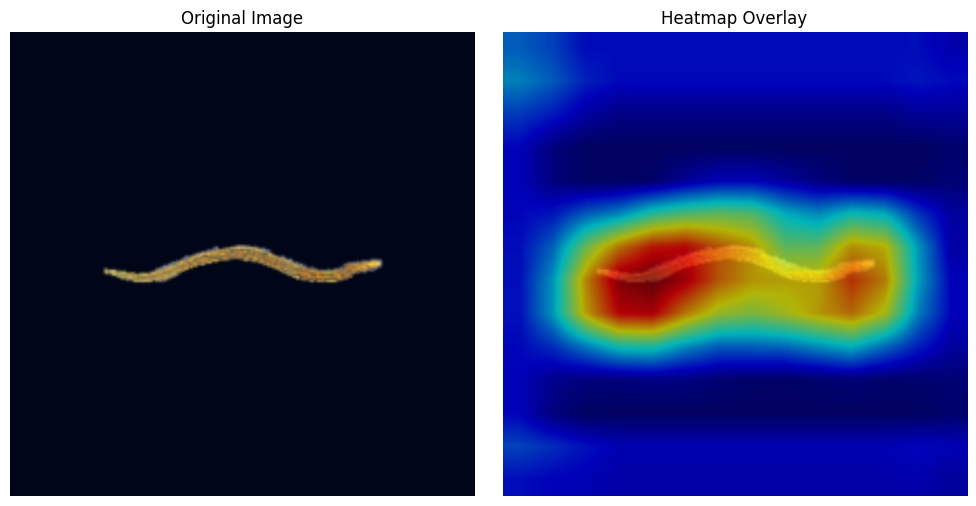

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [ ]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=eta_min)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn, f1_fn],
)

In [ ]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.6927 | Val Loss: 0.6911 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 2 | Train Loss: 0.6870 | Val Loss: 0.6820 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 3 | Train Loss: 0.6645 | Val Loss: 0.6428 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8459 | Val accuracy_fn: 0.8438
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6103 | Val Loss: 0.6068 | Train cohen_kappa_fn: 0.5141 | Val cohen_kappa_fn: 0.4506 | Train accuracy_fn: 0.8409 | Val accuracy_fn: 0.7937
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5606 | Val Loss: 0.5930 | Train cohen_kappa_fn: 0.4756 | Val cohen_kappa_fn: 0.3894 | Train accuracy_fn: 0.7982 | Val accuracy_fn: 0.7406
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5042 | Val Loss: 0.5795 | Train cohen_kappa_fn: 0.3567 | Val cohen_kappa_fn: 0.2749 | Train accuracy_fn: 0.7018 | Val accuracy_fn: 0.6250
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4414 | Val Loss: 0.5154 | Train cohen_kappa_fn: 0.3057 | Val cohen_kappa_fn: 0.2342 | Train accuracy_fn: 0.6516 | Val accuracy_fn: 0.5875
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3791 | Val Loss: 0.3649 | Train cohen_kappa_fn: 0.7900 | Val cohen_kappa_fn: 0.7405 | Train accuracy_fn: 0.9436 | Val accuracy_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3328 | Val Loss: 0.2814 | Train cohen_kappa_fn: 0.7341 | Val cohen_kappa_fn: 0.6818 | Train accuracy_fn: 0.9173 | Val accuracy_fn: 0.9031
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2843 | Val Loss: 0.3446 | Train cohen_kappa_fn: 0.8505 | Val cohen_kappa_fn: 0.7508 | Train accuracy_fn: 0.9612 | Val accuracy_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2450 | Val Loss: 0.2441 | Train cohen_kappa_fn: 0.8428 | Val cohen_kappa_fn: 0.7831 | Train accuracy_fn: 0.9561 | Val accuracy_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2456 | Val Loss: 0.4078 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7057 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9312
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2295 | Val Loss: 0.2477 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7730 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2272 | Val Loss: 0.3069 | Train cohen_kappa_fn: 0.8810 | Val cohen_kappa_fn: 0.7863 | Train accuracy_fn: 0.9687 | Val accuracy_fn: 0.9469
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2082 | Val Loss: 0.3268 | Train cohen_kappa_fn: 0.9001 | Val cohen_kappa_fn: 0.7718 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9438
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1920 | Val Loss: 0.2009 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.8001 | Train accuracy_fn: 0.9536 | Val accuracy_fn: 0.9469
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1785 | Val Loss: 0.2002 | Train cohen_kappa_fn: 0.6348 | Val cohen_kappa_fn: 0.7224 | Train accuracy_fn: 0.8734 | Val accuracy_fn: 0.9125
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1980 | Val Loss: 0.4426 | Train cohen_kappa_fn: 0.8716 | Val cohen_kappa_fn: 0.7481 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9406
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1594 | Val Loss: 0.1977 | Train cohen_kappa_fn: 0.8218 | Val cohen_kappa_fn: 0.8033 | Train accuracy_fn: 0.9474 | Val accuracy_fn: 0.9469
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2134 | Val Loss: 0.2599 | Train cohen_kappa_fn: 0.4897 | Val cohen_kappa_fn: 0.5680 | Train accuracy_fn: 0.7957 | Val accuracy_fn: 0.8406
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2017 | Val Loss: 0.5919 | Train cohen_kappa_fn: 0.8563 | Val cohen_kappa_fn: 0.7002 | Train accuracy_fn: 0.9637 | Val accuracy_fn: 0.9312
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1614 | Val Loss: 0.2157 | Train cohen_kappa_fn: 0.8821 | Val cohen_kappa_fn: 0.8178 | Train accuracy_fn: 0.9674 | Val accuracy_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1604 | Val Loss: 0.2266 | Train cohen_kappa_fn: 0.8554 | Val cohen_kappa_fn: 0.8040 | Train accuracy_fn: 0.9586 | Val accuracy_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1529 | Val Loss: 0.4069 | Train cohen_kappa_fn: 0.2806 | Val cohen_kappa_fn: 0.4074 | Train accuracy_fn: 0.6266 | Val accuracy_fn: 0.7406
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


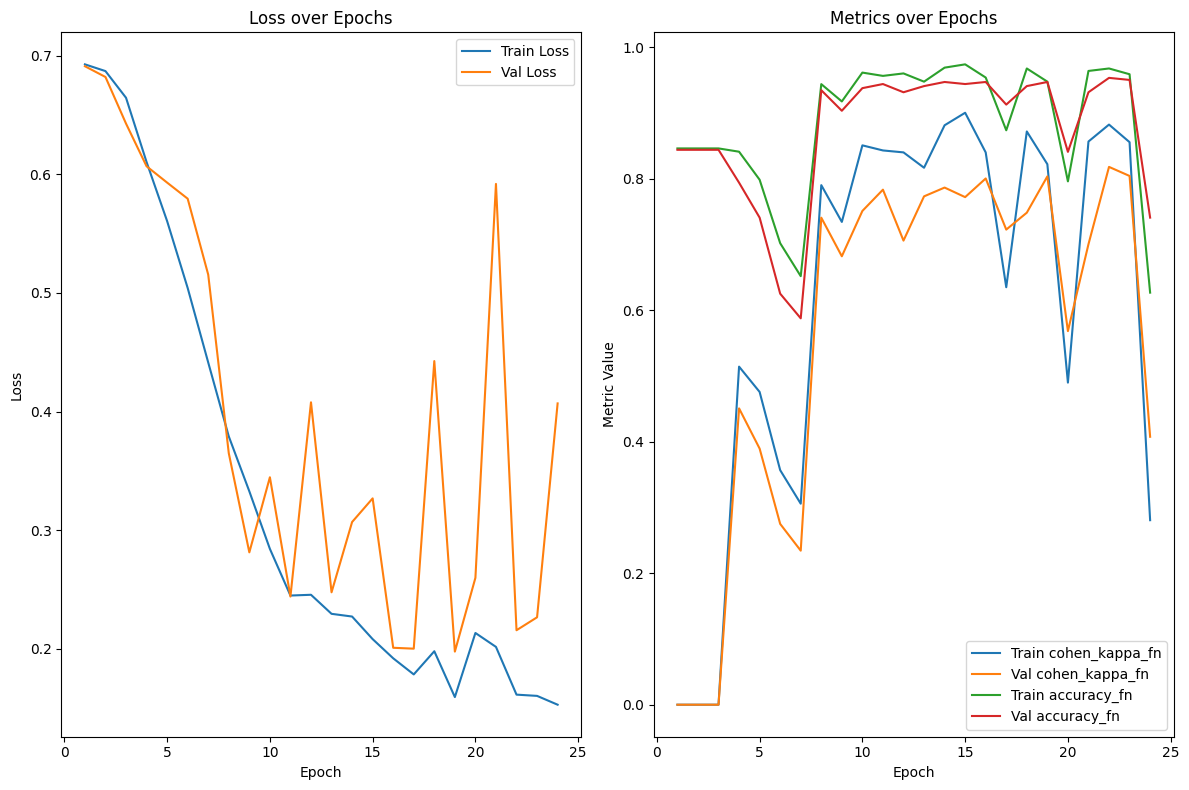

In [ ]:
trainer_cnn_7.plot_epochs()

In [ ]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1579 | Test cohen_kappa_fn: 0.8454 | Test accuracy_fn: 0.9583


#### Visualization

In [ ]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

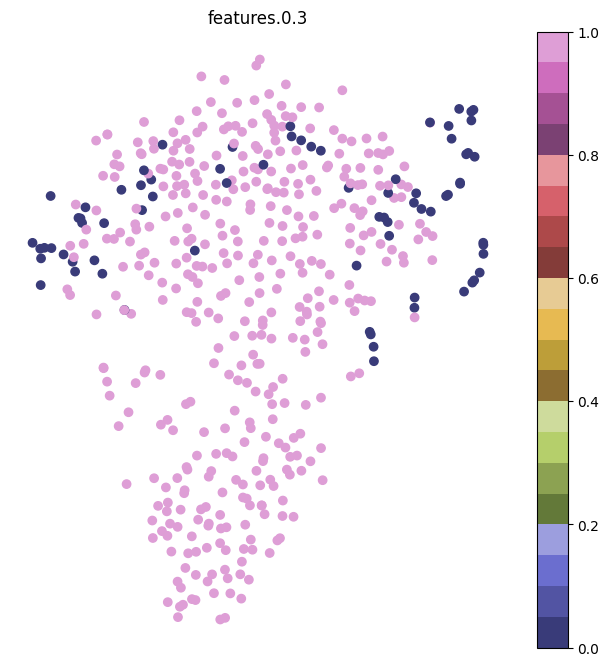

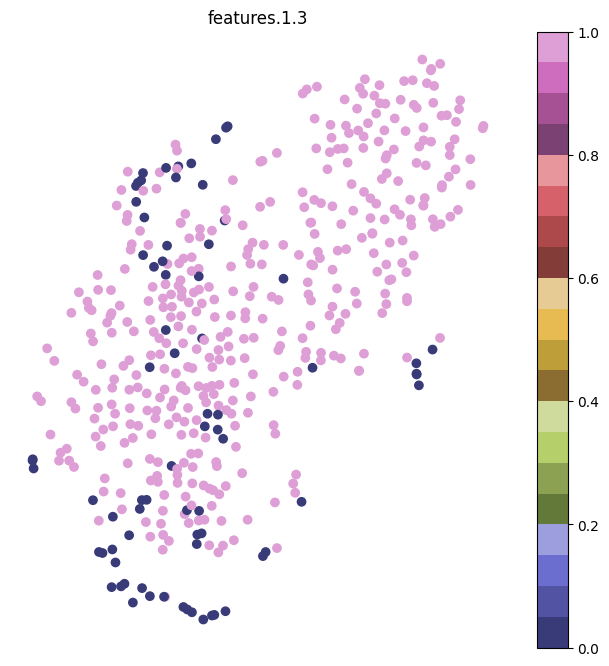

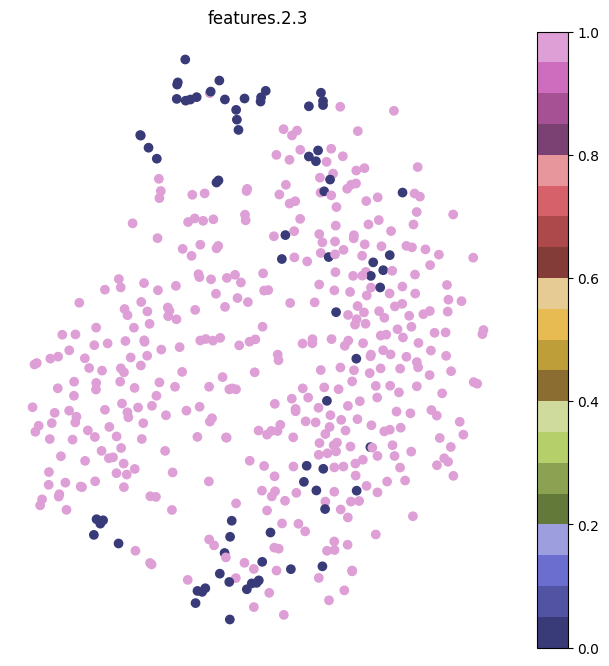

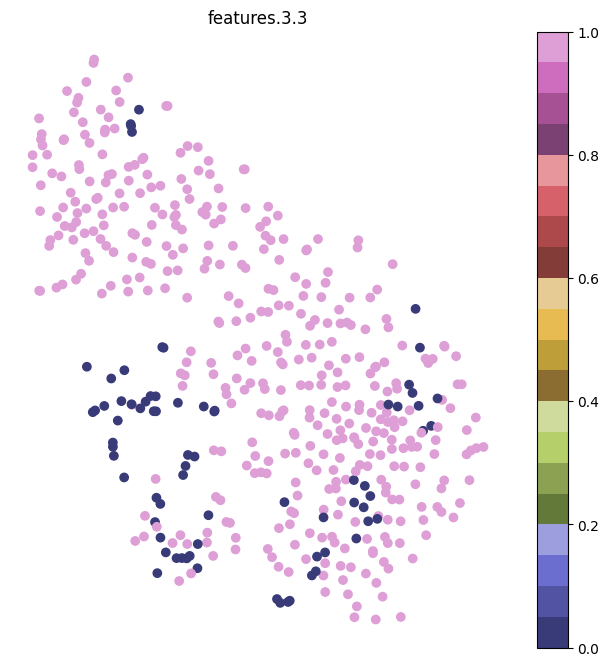

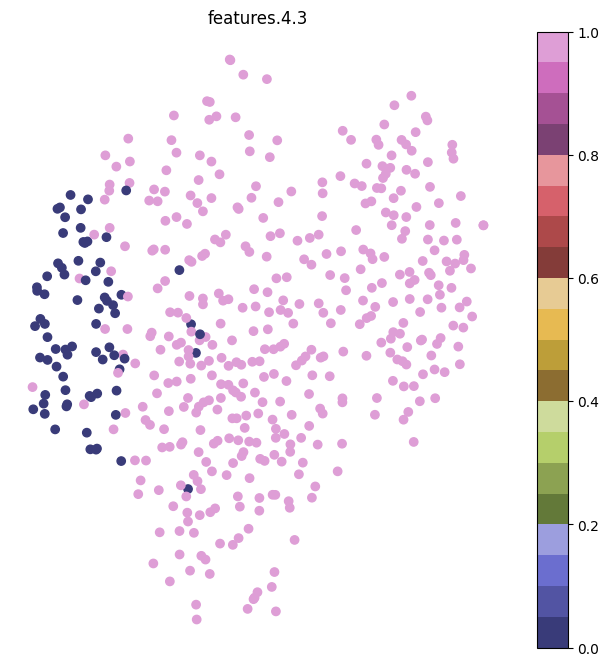

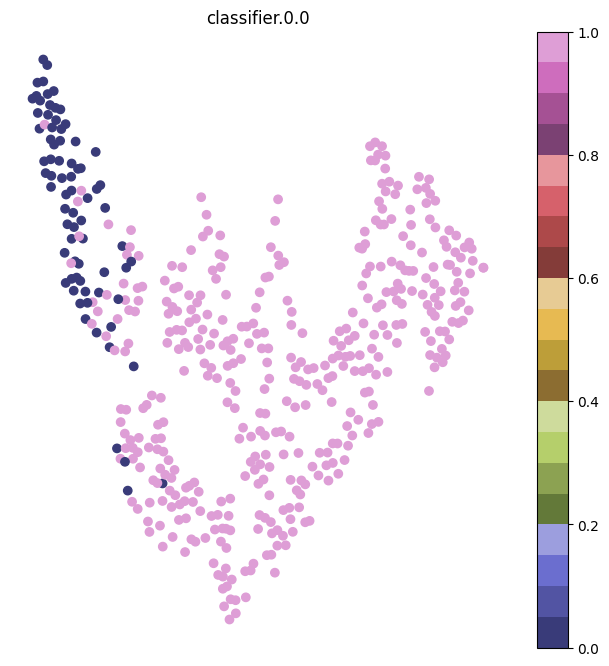

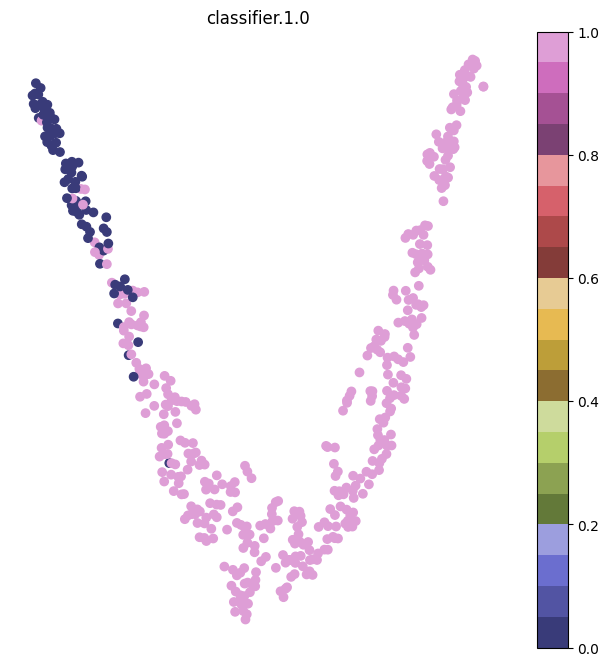

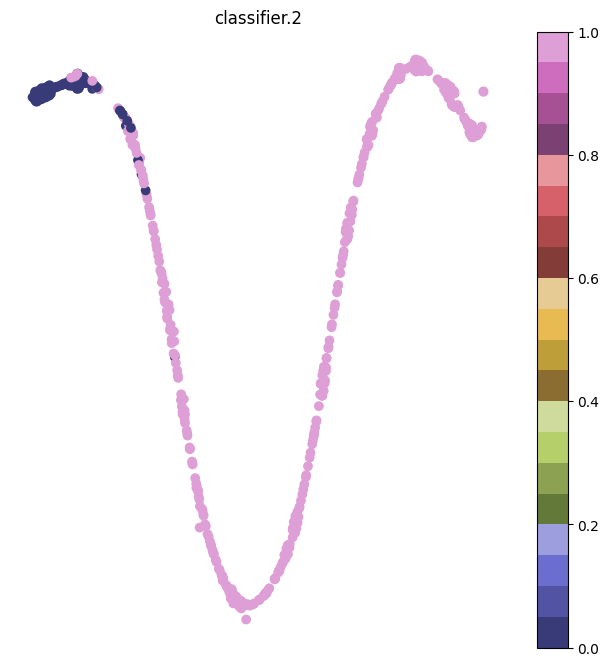

In [ ]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


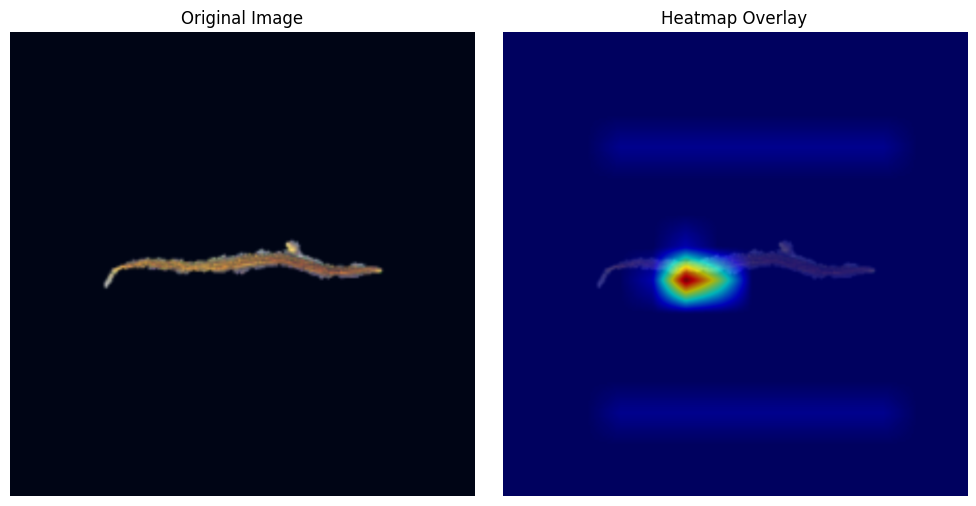

  Generating heatmap for Larvae...
  Predicted label is Larvae!


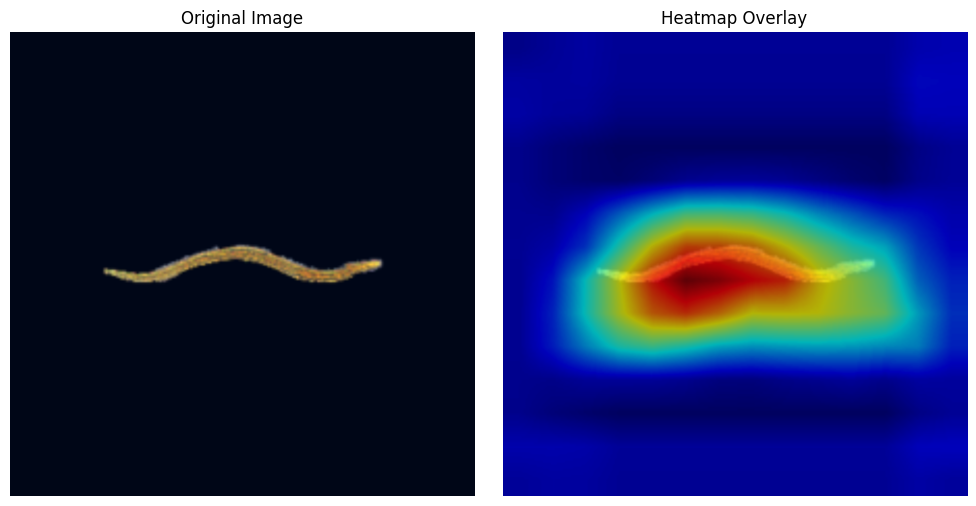

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break